In [8]:
import os
import glob
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import pickle
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
def load_images_from_folder(folder):
    X = []
    y = []
    class_names = sorted(os.listdir(folder))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    for cls_name in tqdm(class_names, desc="Đang load ảnh theo lớp"):
        cls_path = os.path.join(folder, cls_name)
        if not os.path.isdir(cls_path):  
            continue

        image_paths = glob.glob(os.path.join(cls_path, '*.jpg'))

        for img_path in image_paths:
            try:
                img = Image.open(img_path)
                img_np = np.array(img).flatten() / 255.0  
                X.append(img_np)
                y.append(class_to_idx[cls_name]) 
            except Exception as e:
                print(f"Lỗi khi xử lý {img_path}: {e}")
    
    return np.array(X), np.array(y), class_to_idx

In [3]:
def predict_images_from_folder(folder, svm_model, class_to_idx):
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    image_paths = glob.glob(os.path.join(folder, '*.jpg'))

    print("📷 Dự đoán các ảnh trong thư mục:", folder)
    for img_path in image_paths:
        try:
            img = Image.open(img_path).resize((50, 150)).convert("L")
            img_np = np.array(img).flatten() / 255.0  # chuẩn hóa
            img_np = img_np.reshape(1, -1)  # reshape thành 2D để predict

            pred_idx = svm_model.predict(img_np)[0]
            pred_class = idx_to_class[pred_idx]

            print(f"🖼️ {os.path.basename(img_path)} → Dự đoán: {pred_class}")
        except Exception as e:
            print(f"❌ Lỗi khi xử lý ảnh {img_path}: {e}")


In [4]:
# Hàm vẽ ma trận nhầm lẫn
def plot_confusion_matrix(y_true, y_pred, title, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
# Load dữ liệu train/test từ thư mục
X_train, y_train, class_to_idx = load_images_from_folder('../anhmoi')
X_test, y_test, _ = load_images_from_folder('preprocessed_data/test')

Đang load ảnh theo lớp: 100%|██████████| 29/29 [00:00<00:00, 33.62it/s]


In [6]:
# Chuẩn bị dữ liệu cho CNN (dữ liệu 3D)
X_train_cnn = X_train.reshape(-1, 50, 150, 1)
X_test_cnn = X_test.reshape(-1, 50, 150, 1)



In [9]:
# Chuyển đổi dữ liệu sang tensor cho tensorflow
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [ ]:
# # Huấn luyện bằng XGBoost
# xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
# xgb_model.fit(X_train, y_train)
# y_pred_xgb = xgb_model.predict(X_test)
# print("🔸 XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
# with open('save_model/xgb_model.pkl', 'wb') as f:
#     pickle.dump(xgb_model, f)

In [12]:
all_predictions = {}

In [10]:
# --- Huấn luyện bằng SVM với RBF---
svm_rbf_model = SVC(kernel='rbf', C=10)
svm_rbf_model.fit(X_train, y_train)
y_pred_svm = svm_rbf_model.predict(X_test)
print("🔸 SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

with open('./save_model/svm_rbf_model.pkl', 'wb') as f:
    pickle.dump(svm_rbf_model, f)

🔸 SVM Accuracy: 0.9388770433546553


In [14]:
# SVM với SGD (OneVsRest)
svm_sgd_ovr = OneVsRestClassifier(SGDClassifier(loss='hinge', max_iter=1000, learning_rate='optimal', random_state=42))
svm_sgd_ovr.fit(X_train, y_train)
y_pred_svm_sgd = svm_sgd_ovr.predict(X_test)
print("🔸 SVM (SGD - OneVsRest) Accuracy:", accuracy_score(y_test, y_pred_svm_sgd))
with open('save_model/svm_sgd_ovr_model.pkl', 'wb') as f:
    pickle.dump(svm_sgd_ovr, f)
all_predictions['SVM (SGD - OneVsRest)'] = y_pred_svm_sgd

🔸 SVM (SGD - OneVsRest) Accuracy: 0.6389481165600569


In [15]:
optimizers = ['gd', 'sgd', 'adam', 'adagrad']

In [ ]:
# SVM tuyến tính với tensorflow
class LinearSVM:
    def __init__(self, input_dim, num_classes):
        self.W = tf.Variable(tf.zeros([input_dim, num_classes], dtype=tf.float32), name='weights')
        self.b = tf.Variable(tf.zeros([num_classes], dtype=tf.float32), name='bias')
    
    def predict(self, X):
        scores = tf.matmul(X, self.W) + self.b
        return tf.argmax(scores, axis=1)

def train_linear_svm(optimizer_name, epochs=100):
    model = LinearSVM(X_train.shape[1], len(class_to_idx))
    if optimizer_name == 'gd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    elif optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    elif optimizer_name == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            scores = tf.matmul(X_train_tf, model.W) + model.b
            y_one_hot = tf.one_hot(y_train_tf, len(class_to_idx))
            margins = tf.maximum(0.0, 1.0 - y_one_hot * scores)
            loss = tf.reduce_mean(margins) + 0.5 * tf.reduce_sum(tf.square(model.W))
        gradients = tape.gradient(loss, [model.W, model.b])
        optimizer.apply_gradients(zip(gradients, [model.W, model.b]))
    return model

for opt in optimizers:
    print(f"\nHuấn luyện SVM tuyến tính với optimizer: {opt.upper()}")
    model = train_linear_svm(opt, epochs=100)
    y_pred_tf = model.predict(X_test_tf).numpy()
    accuracy = accuracy_score(y_test, y_pred_tf)
    print(f"🔸 SVM (Linear, {opt.upper()}) Accuracy:", accuracy)
    all_predictions[f'SVM (Linear, {opt.upper()})'] = y_pred_tf
    with open(f'save_model/svm_linear_{opt}_weights.pkl', 'wb') as f:
        pickle.dump({'W': model.W.numpy(), 'b': model.b.numpy()}, f)


Huấn luyện SVM tuyến tính với optimizer: GD
🔸 SVM (Linear, GD) Accuracy: 0.15707178393745558

Huấn luyện SVM tuyến tính với optimizer: SGD
🔸 SVM (Linear, SGD) Accuracy: 0.15707178393745558

Huấn luyện SVM tuyến tính với optimizer: ADAM
🔸 SVM (Linear, ADAM) Accuracy: 0.030561478322672354

Huấn luyện SVM tuyến tính với optimizer: ADAGRAD
🔸 SVM (Linear, ADAGRAD) Accuracy: 0.20113717128642503



Huấn luyện SVM tuyến tính với optimizer: GD, lr=0.01, C=0.1


Training with GD:   0%|          | 0/200 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'optimizer'

In [17]:
# Huấn luyện bằng Logistic Regression (LBFGS)
logistic_lbfs_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_lbfs_model.fit(X_train, y_train)
y_pred_logistic = logistic_lbfs_model.predict(X_test)
print("🔹 Logistic Regression (LBFGS) Accuracy:", accuracy_score(y_test, y_pred_logistic))
with open('save_model/logistic_lbfs_model.pkl', 'wb') as f:
    pickle.dump(logistic_lbfs_model, f)
all_predictions['Logistic Regression (LBFGS)'] = y_pred_logistic

c:\Users\admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


🔹 Logistic Regression (LBFGS) Accuracy: 0.7739872068230277


In [18]:
# Huấn luyện bằng Logistic Regression (Newton-CG)
logistic_newton_model = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=1000)
logistic_newton_model.fit(X_train, y_train)
y_pred_logistic_newton = logistic_newton_model.predict(X_test)
print("🔹 Logistic Regression (Newton-CG) Accuracy:", accuracy_score(y_test, y_pred_logistic_newton))
with open('save_model/logistic_newton_model.pkl', 'wb') as f:
    pickle.dump(logistic_newton_model, f)
all_predictions['Logistic Regression (Newton-CG)'] = y_pred_logistic_newton

c:\Users\admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


🔹 Logistic Regression (Newton-CG) Accuracy: 0.7746979388770433


In [24]:
# Huấn luyện bằng Logistic Regression (đo) - tốt cho dữ liệu có đặc trưng > số mẫu
logistic_liblinear_model = LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=100)
logistic_liblinear_model.fit(X_train, y_train)
y_pred_liblinear = logistic_liblinear_model.predict(X_test)
print("🔹 Logistic Regression (Liblinear) Accuracy:", accuracy_score(y_test, y_pred_liblinear))
with open('save_model/logistic_liblinear_model.pkl', 'wb') as f:
    pickle.dump(logistic_liblinear_model, f)
all_predictions['Logistic Regression (Liblinear)'] = y_pred_liblinear

c:\Users\admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


🔹 Logistic Regression (Liblinear) Accuracy: 0.7704335465529495


In [ ]:
# # Logistic Regression với tensorflow
# class LogisticRegressionTF:
#     def __init__(self, input_dim, num_classes):
#         self.W = tf.Variable(tf.zeros([input_dim, num_classes], dtype=tf.float32), name='weights')
#         self.b = tf.Variable(tf.zeros([num_classes], dtype=tf.float32), name='bias')
    
#     def predict(self, X):
#         logits = tf.matmul(X, self.W) + self.b
#         return tf.argmax(logits, axis=1)

# def train_logistic_regression(optimizer_name, epochs=100):
#     model = LogisticRegressionTF(X_train.shape[1], len(class_to_idx))
#     if optimizer_name == 'gd':
#         optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
#     elif optimizer_name == 'sgd':
#         optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
#     elif optimizer_name == 'adam':
#         optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
#     elif optimizer_name == 'adagrad':
#         optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)

#     for epoch in range(epochs):
#         with tf.GradientTape() as tape:
#             logits = tf.matmul(X_train_tf, model.W) + model.b
#             loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_train_tf, logits=logits))
#         gradients = tape.gradient(loss, [model.W, model.b])
#         optimizer.apply_gradients(zip(gradients, [model.W, model.b]))
#     return model

# for opt in optimizers:
#     print(f"\nHuấn luyện Logistic Regression với optimizer: {opt.upper()}")
#     model = train_logistic_regression(opt, epochs=100)
#     y_pred_tf = model.predict(X_test_tf).numpy()
#     accuracy = accuracy_score(y_test, y_pred_tf)
#     print(f"🔹 Logistic Regression ({opt.upper()}) Accuracy:", accuracy)
#     all_predictions[f'Logistic Regression ({opt.upper()})'] = y_pred_tf
#     with open(f'save_model/logistic_{opt}_weights.pkl', 'wb') as f:
#         pickle.dump({'W': model.W.numpy(), 'b': model.b.numpy()}, f)


Huấn luyện Logistic Regression với optimizer: GD
🔹 Logistic Regression (GD) Accuracy: 0.4129353233830846

Huấn luyện Logistic Regression với optimizer: SGD
🔹 Logistic Regression (SGD) Accuracy: 0.4129353233830846

Huấn luyện Logistic Regression với optimizer: ADAM
🔹 Logistic Regression (ADAM) Accuracy: 0.47334754797441364

Huấn luyện Logistic Regression với optimizer: ADAGRAD
🔹 Logistic Regression (ADAGRAD) Accuracy: 0.42786069651741293


In [20]:
# Huấn luyện bằng KNN
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print("🔸 KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
with open('save_model/knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)
all_predictions['KNN'] = y_pred_knn

🔸 KNN Accuracy: 0.8479033404406539


In [21]:
# Huấn luyện bằng Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("🔸 Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
with open('save_model/dt_model.pkl', 'wb') as f:
    pickle.dump(dt_model, f)
all_predictions['Decision Tree'] = y_pred_dt

🔸 Decision Tree Accuracy: 0.5778251599147122


In [22]:
# Huấn luyện bằng Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("🔸 Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
with open('save_model/nb_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)
all_predictions['Naive Bayes'] = y_pred_nb

🔸 Naive Bayes Accuracy: 0.6204690831556503


In [ ]:
# # Huấn luyện bằng XGBoost
# xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
# xgb_model.fit(X_train, y_train)
# y_pred_xgb = xgb_model.predict(X_test)
# print("🔸 XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
# with open('save_model/xgb_model.pkl', 'wb') as f:
#     pickle.dump(xgb_model, f)
# all_predictions['XGBoost'] = y_pred_xgb

In [ ]:
# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))

# Vẽ ma trận nhầm lẫn
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


Huấn luyện SVM tuyến tính với optimizer: GD, lr=0.01, C=0.1


Training with GD: 100%|██████████| 200/200 [00:10<00:00, 19.92it/s]



Đánh giá mô hình SVM (Linear, GD, lr=0.01, C=0.1):
Accuracy: 0.3468
Precision: 0.3512
Recall: 0.3468
F1-score: 0.3432


<Figure size 1000x800 with 0 Axes>

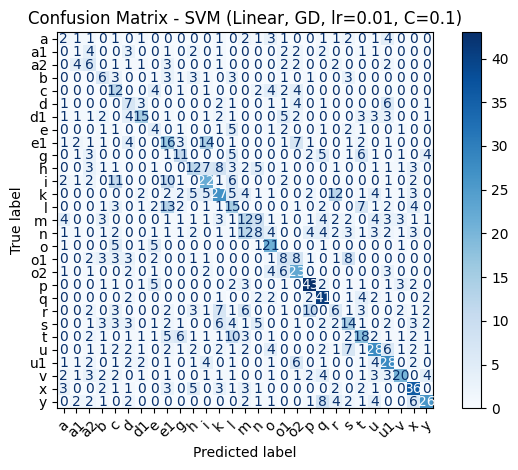

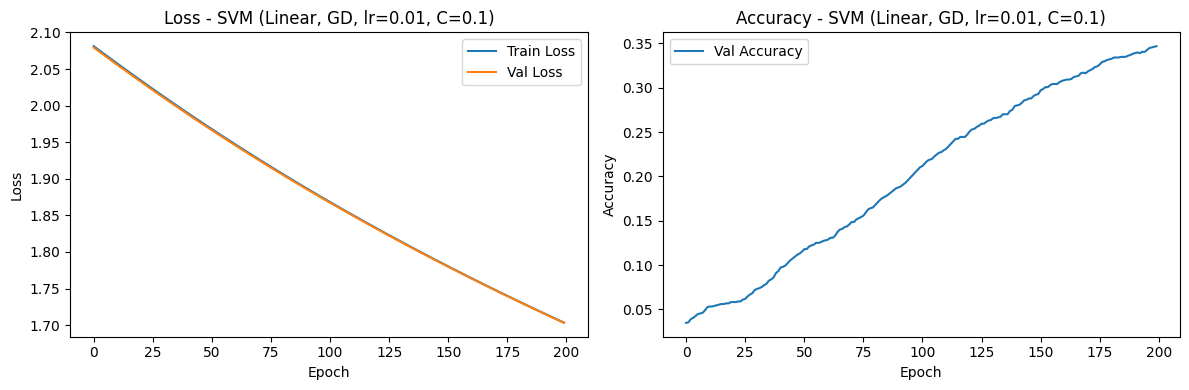


Huấn luyện SVM tuyến tính với optimizer: GD, lr=0.01, C=1.0


Training with GD: 100%|██████████| 200/200 [00:09<00:00, 20.79it/s]
c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Đánh giá mô hình SVM (Linear, GD, lr=0.01, C=1.0):
Accuracy: 0.5743
Precision: 0.5719
Recall: 0.5743
F1-score: 0.5423


<Figure size 1000x800 with 0 Axes>

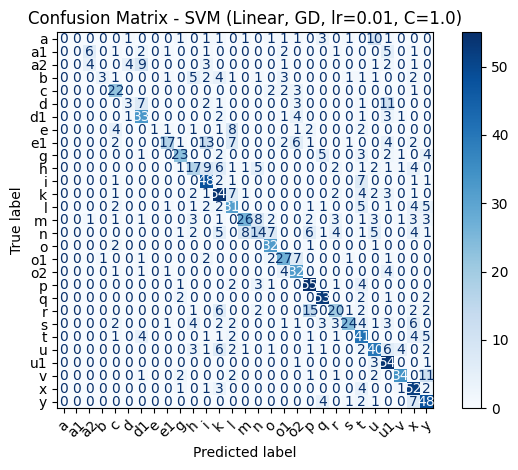

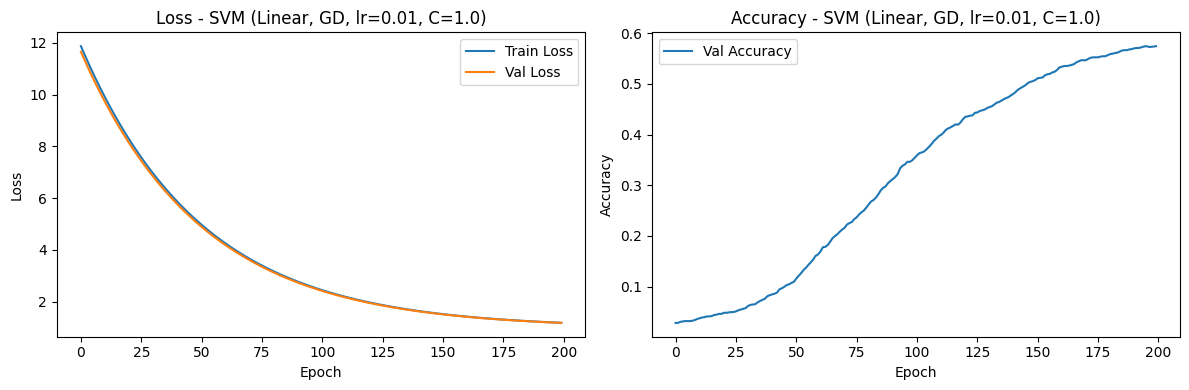


Huấn luyện SVM tuyến tính với optimizer: GD, lr=0.001, C=0.1


Training with GD: 100%|██████████| 200/200 [00:09<00:00, 21.80it/s]



Đánh giá mô hình SVM (Linear, GD, lr=0.001, C=0.1):
Accuracy: 0.0746
Precision: 0.0748
Recall: 0.0746
F1-score: 0.0728


<Figure size 1000x800 with 0 Axes>

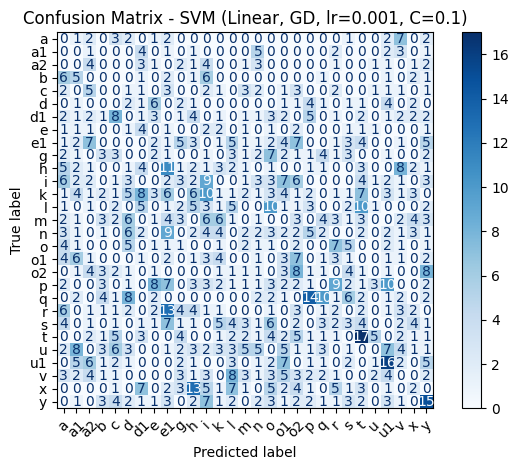

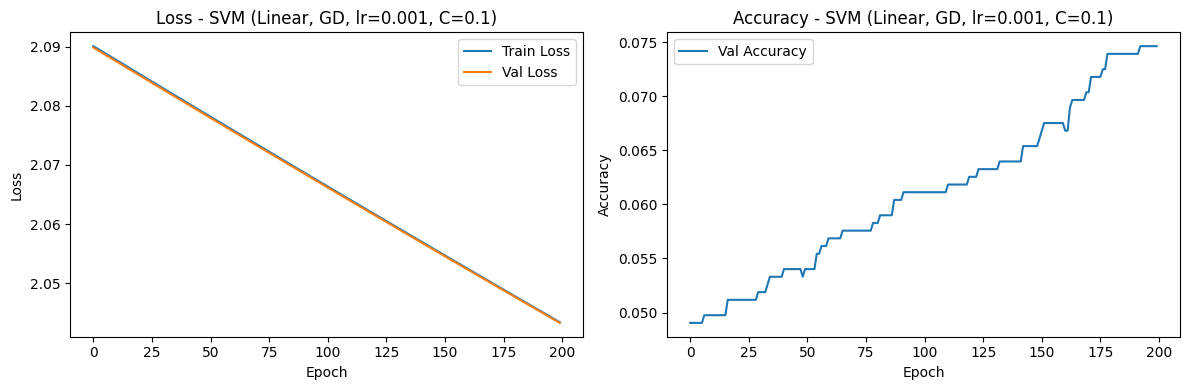


Huấn luyện SVM tuyến tính với optimizer: GD, lr=0.001, C=1.0


Training with GD: 100%|██████████| 200/200 [00:09<00:00, 21.23it/s]



Đánh giá mô hình SVM (Linear, GD, lr=0.001, C=1.0):
Accuracy: 0.0803
Precision: 0.0743
Recall: 0.0803
F1-score: 0.0756


<Figure size 1000x800 with 0 Axes>

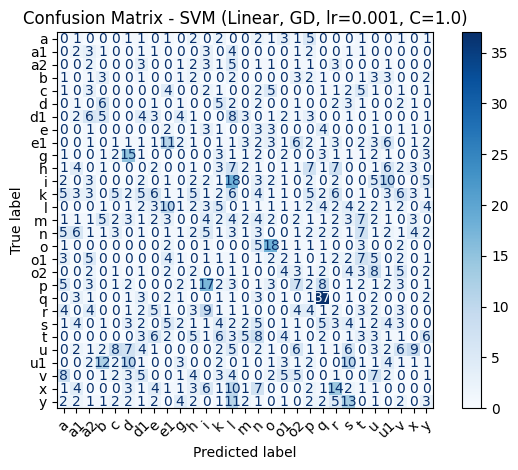

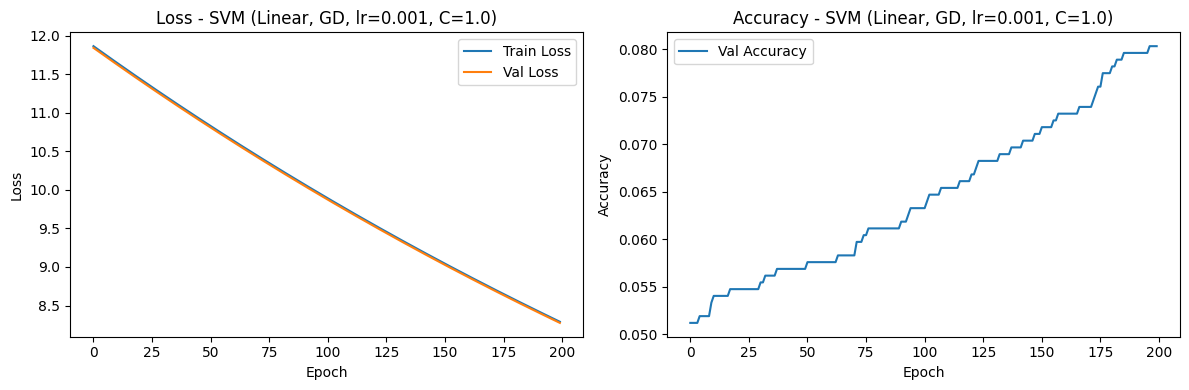


Huấn luyện SVM tuyến tính với optimizer: SGD, lr=0.01, C=0.1


Training with SGD:  12%|█▎        | 25/200 [00:23<02:49,  1.03it/s]

Giảm learning rate xuống 0.005 tại epoch 25


Training with SGD: 100%|██████████| 200/200 [03:06<00:00,  1.07it/s]



Đánh giá mô hình SVM (Linear, SGD, lr=0.01, C=0.1):
Accuracy: 0.6567
Precision: 0.6893
Recall: 0.6567
F1-score: 0.6539


<Figure size 1000x800 with 0 Axes>

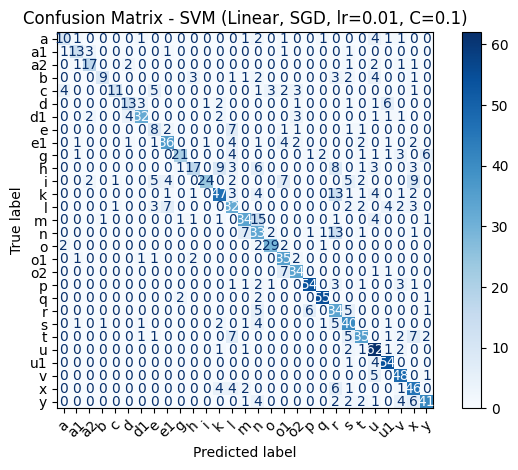

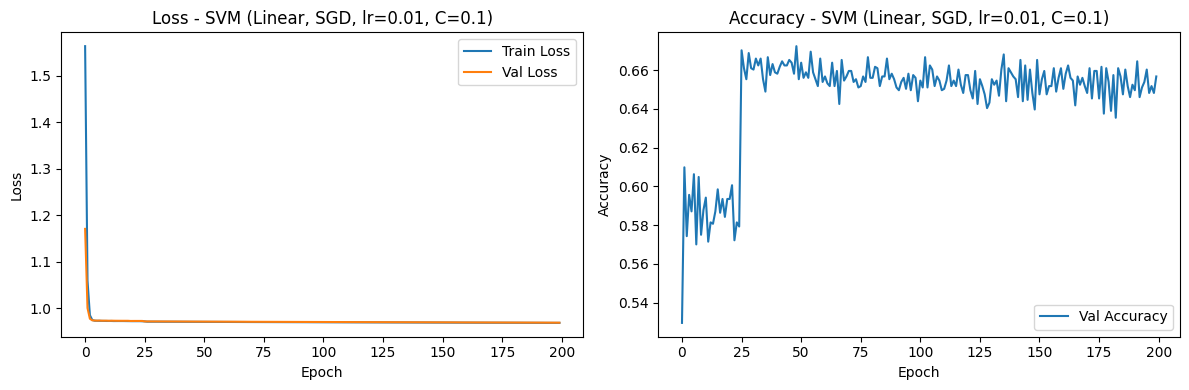


Huấn luyện SVM tuyến tính với optimizer: SGD, lr=0.01, C=1.0


Training with SGD:  90%|████████▉ | 179/200 [02:51<00:19,  1.10it/s]

Giảm learning rate xuống 0.005 tại epoch 179


Training with SGD:  92%|█████████▏| 183/200 [02:56<00:16,  1.04it/s]

Early stopping at epoch 184

Đánh giá mô hình SVM (Linear, SGD, lr=0.01, C=1.0):
Accuracy: 0.3070
Precision: 0.3236
Recall: 0.3070
F1-score: 0.2692



c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

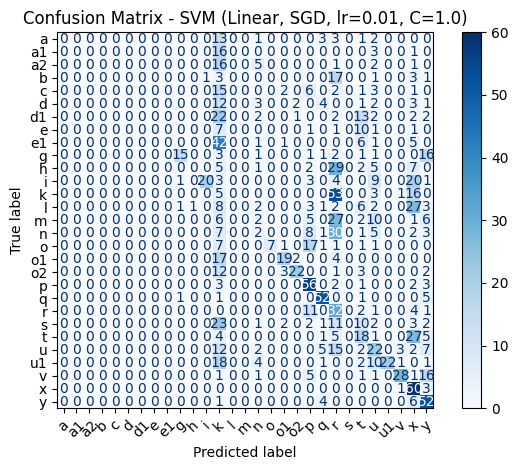

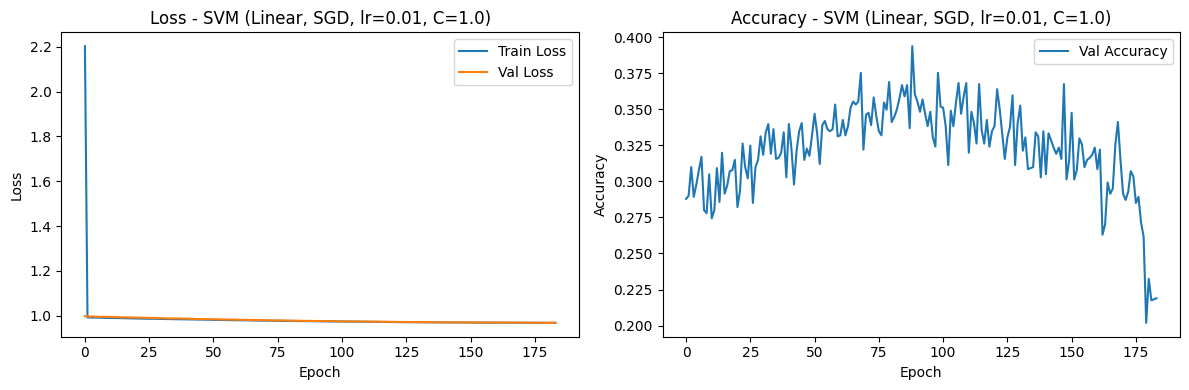


Huấn luyện SVM tuyến tính với optimizer: SGD, lr=0.001, C=0.1


Training with SGD: 100%|██████████| 200/200 [03:09<00:00,  1.05it/s]



Đánh giá mô hình SVM (Linear, SGD, lr=0.001, C=0.1):
Accuracy: 0.6866
Precision: 0.7069
Recall: 0.6866
F1-score: 0.6885


<Figure size 1000x800 with 0 Axes>

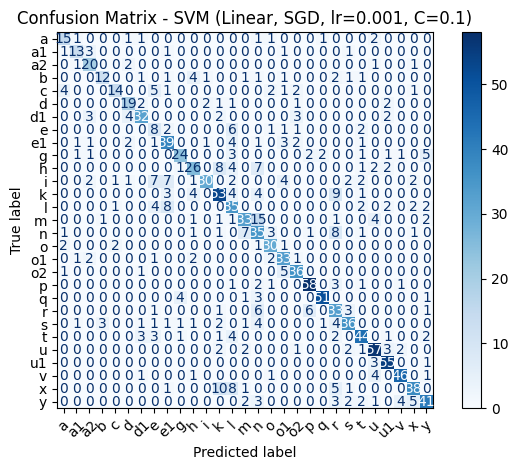

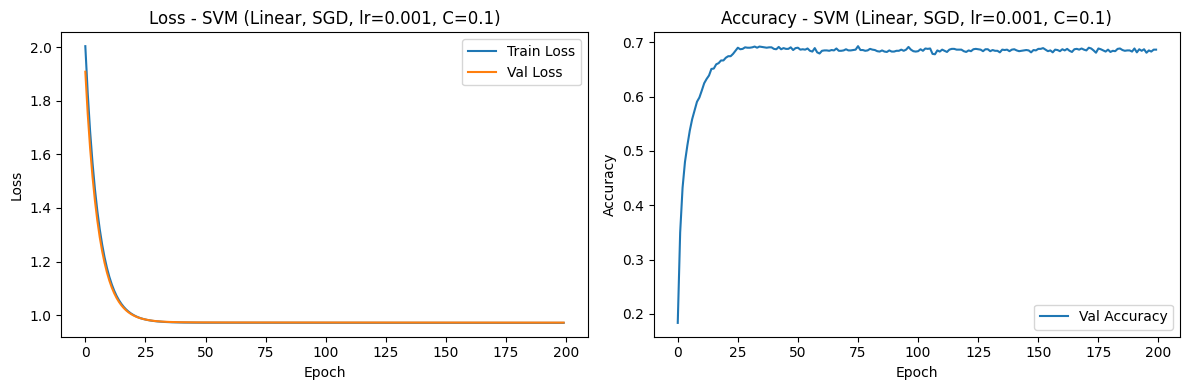


Huấn luyện SVM tuyến tính với optimizer: SGD, lr=0.001, C=1.0


Training with SGD: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]
c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Đánh giá mô hình SVM (Linear, SGD, lr=0.001, C=1.0):
Accuracy: 0.5757
Precision: 0.5607
Recall: 0.5757
F1-score: 0.5382


<Figure size 1000x800 with 0 Axes>

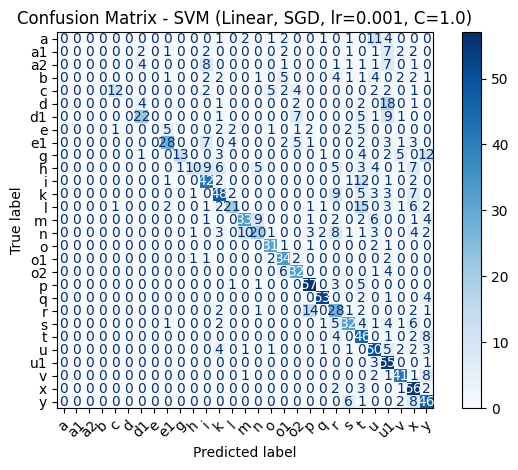

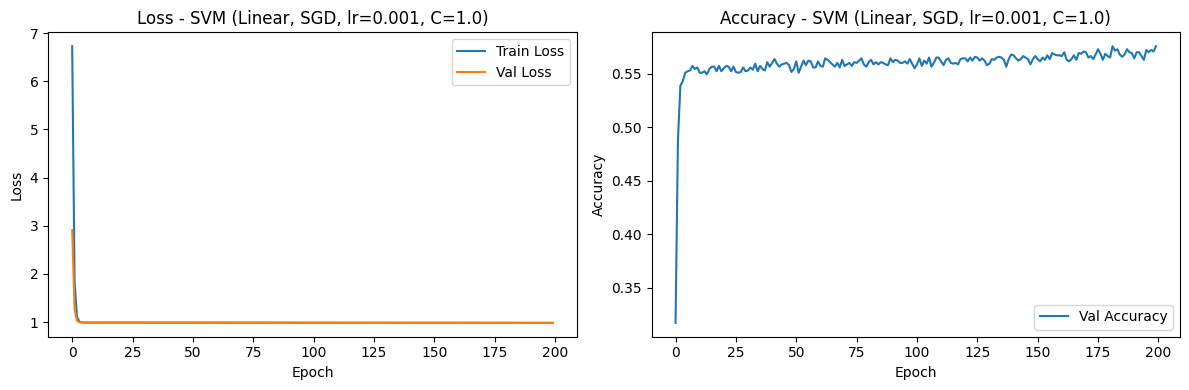


Huấn luyện SVM tuyến tính với optimizer: ADAM, lr=0.01, C=0.1


Training with ADAM:   6%|▋         | 13/200 [00:19<04:43,  1.52s/it]

Giảm learning rate xuống 0.005 tại epoch 13


Training with ADAM:   8%|▊         | 17/200 [00:27<04:52,  1.60s/it]

Early stopping at epoch 18

Đánh giá mô hình SVM (Linear, ADAM, lr=0.01, C=0.1):
Accuracy: 0.0291
Precision: 0.0008
Recall: 0.0291
F1-score: 0.0017



c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

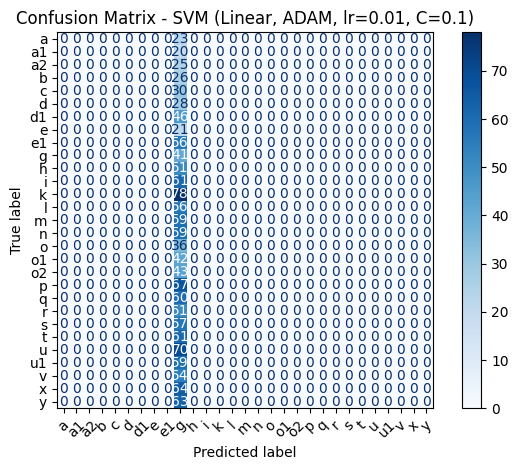

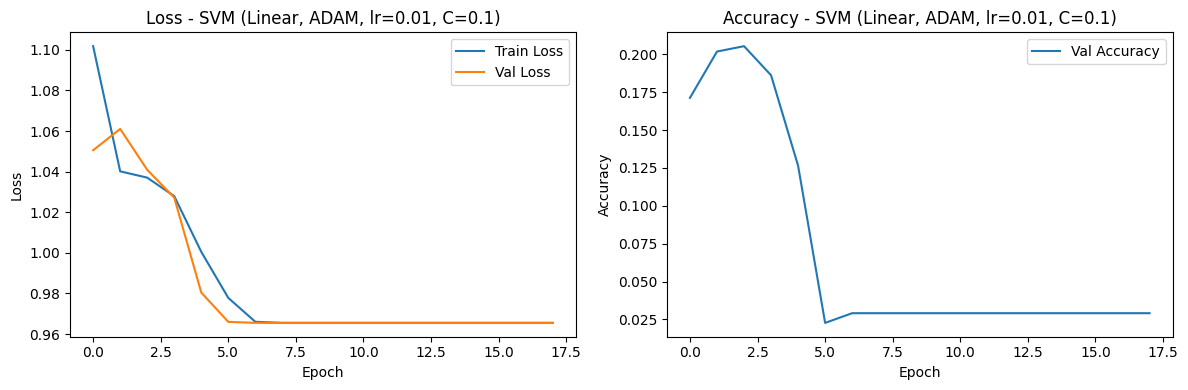


Huấn luyện SVM tuyến tính với optimizer: ADAM, lr=0.01, C=1.0


Training with ADAM:   6%|▌         | 11/200 [00:16<04:38,  1.47s/it]

Giảm learning rate xuống 0.005 tại epoch 11


Training with ADAM:   8%|▊         | 15/200 [00:24<04:56,  1.60s/it]

Early stopping at epoch 16

Đánh giá mô hình SVM (Linear, ADAM, lr=0.01, C=1.0):
Accuracy: 0.0398
Precision: 0.0016
Recall: 0.0398
F1-score: 0.0030



c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

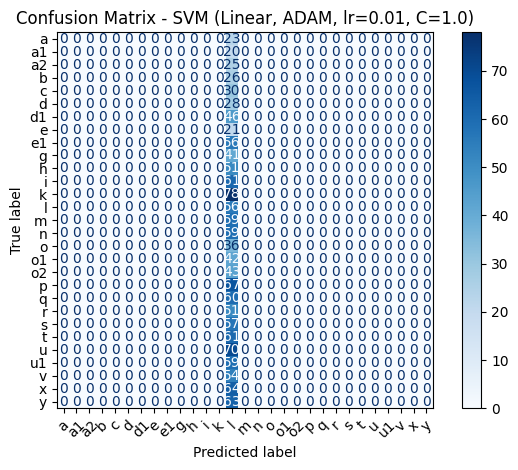

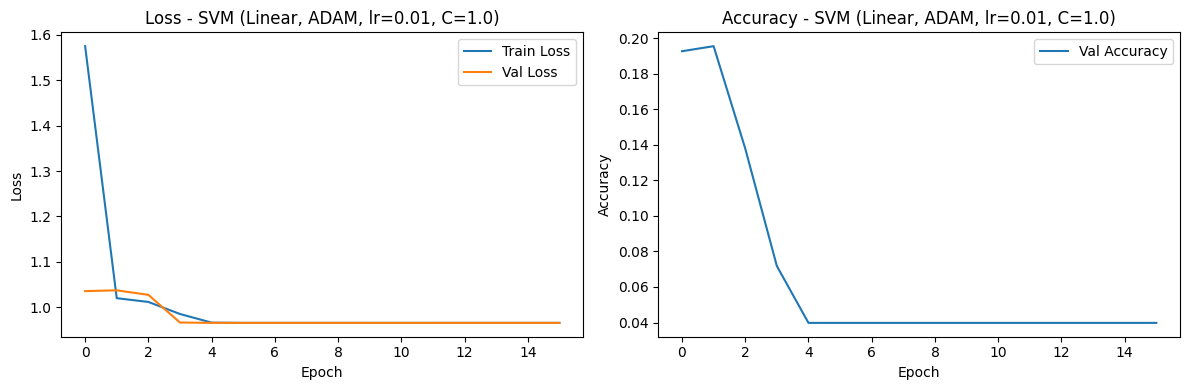


Huấn luyện SVM tuyến tính với optimizer: ADAM, lr=0.001, C=0.1


Training with ADAM:  34%|███▎      | 67/200 [01:38<03:13,  1.46s/it]

Giảm learning rate xuống 0.0005 tại epoch 67


Training with ADAM:  36%|███▋      | 73/200 [01:47<03:04,  1.46s/it]

Giảm learning rate xuống 0.00025 tại epoch 73


Training with ADAM:  38%|███▊      | 77/200 [01:54<03:02,  1.49s/it]

Early stopping at epoch 78

Đánh giá mô hình SVM (Linear, ADAM, lr=0.001, C=0.1):
Accuracy: 0.0398
Precision: 0.0016
Recall: 0.0398
F1-score: 0.0030



c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

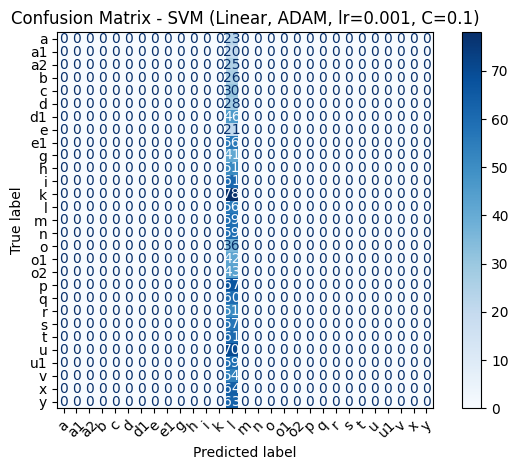

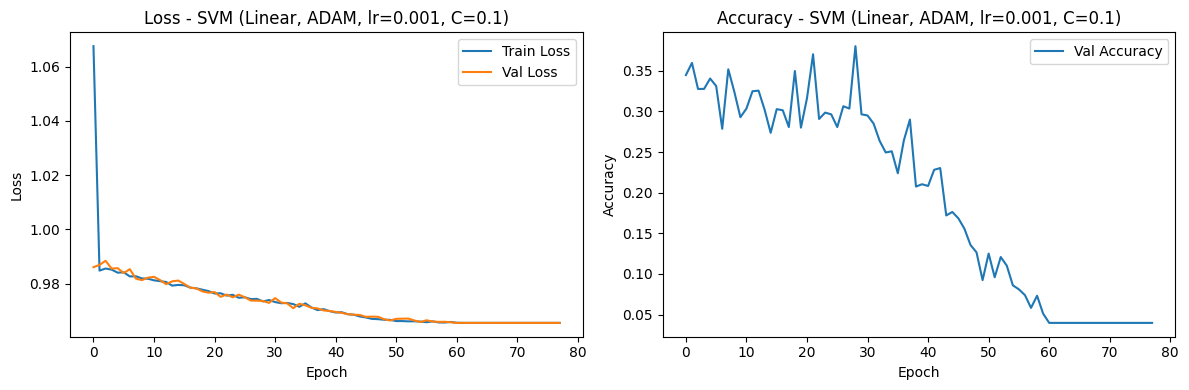


Huấn luyện SVM tuyến tính với optimizer: ADAM, lr=0.001, C=1.0


Training with ADAM:  24%|██▍       | 49/200 [01:12<03:33,  1.42s/it]

Giảm learning rate xuống 0.0005 tại epoch 49


Training with ADAM:  28%|██▊       | 55/200 [01:21<03:36,  1.49s/it]

Giảm learning rate xuống 0.00025 tại epoch 55


Training with ADAM:  30%|██▉       | 59/200 [01:28<03:32,  1.51s/it]

Early stopping at epoch 60

Đánh giá mô hình SVM (Linear, ADAM, lr=0.001, C=1.0):
Accuracy: 0.0554
Precision: 0.0031
Recall: 0.0554
F1-score: 0.0058



c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

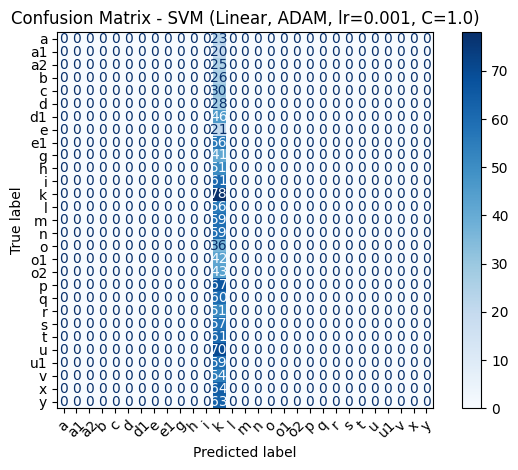

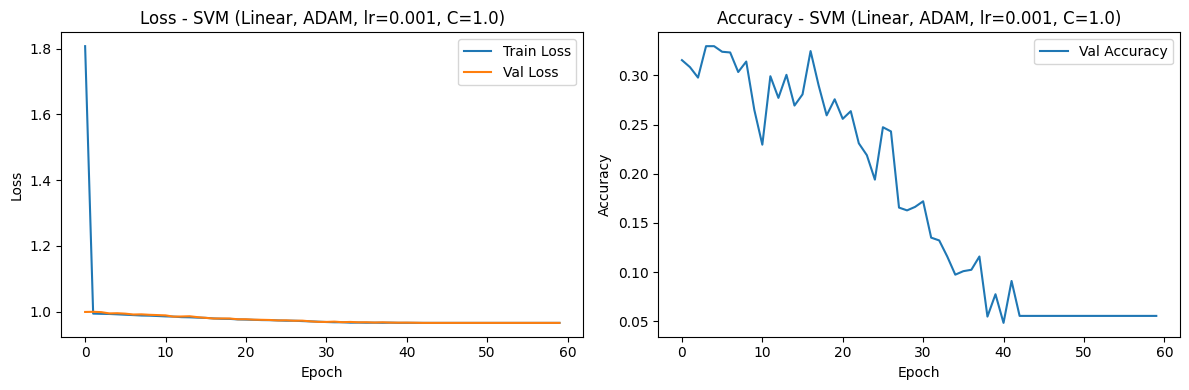


Huấn luyện SVM tuyến tính với optimizer: ADAGRAD, lr=0.01, C=0.1


Training with ADAGRAD: 100%|██████████| 200/200 [03:01<00:00,  1.10it/s]



Đánh giá mô hình SVM (Linear, ADAGRAD, lr=0.01, C=0.1):
Accuracy: 0.6596
Precision: 0.6848
Recall: 0.6596
F1-score: 0.6570


<Figure size 1000x800 with 0 Axes>

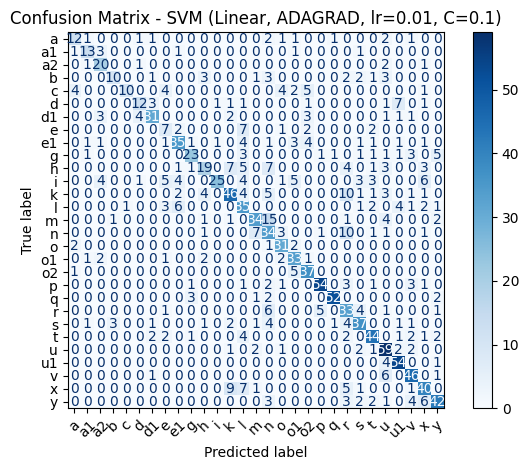

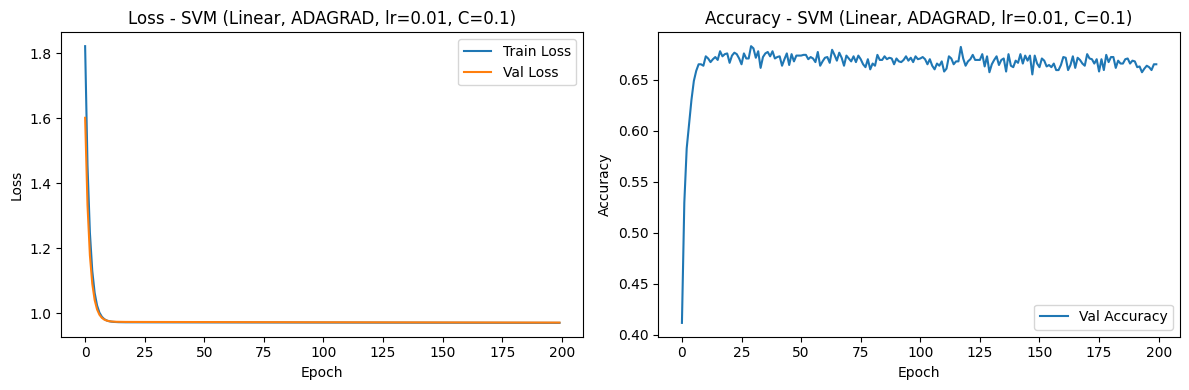


Huấn luyện SVM tuyến tính với optimizer: ADAGRAD, lr=0.01, C=1.0


Training with ADAGRAD: 100%|██████████| 200/200 [03:02<00:00,  1.10it/s]
c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Đánh giá mô hình SVM (Linear, ADAGRAD, lr=0.01, C=1.0):
Accuracy: 0.4954
Precision: 0.4396
Recall: 0.4954
F1-score: 0.4297


<Figure size 1000x800 with 0 Axes>

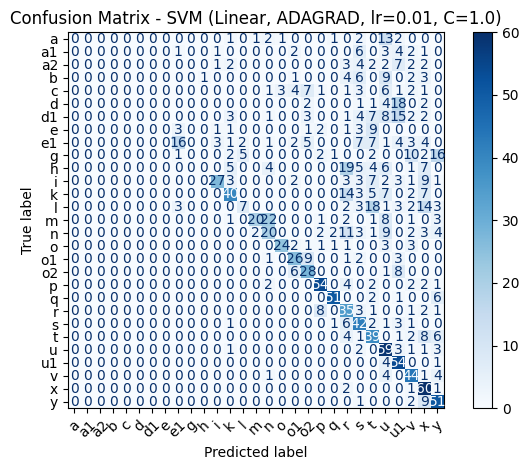

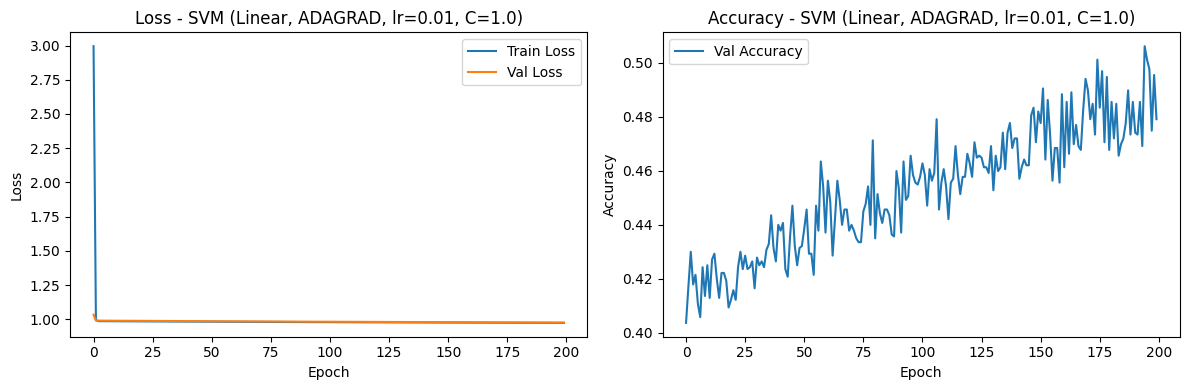


Huấn luyện SVM tuyến tính với optimizer: ADAGRAD, lr=0.001, C=0.1


Training with ADAGRAD: 100%|██████████| 200/200 [03:00<00:00,  1.11it/s]



Đánh giá mô hình SVM (Linear, ADAGRAD, lr=0.001, C=0.1):
Accuracy: 0.6837
Precision: 0.7032
Recall: 0.6837
F1-score: 0.6858


<Figure size 1000x800 with 0 Axes>

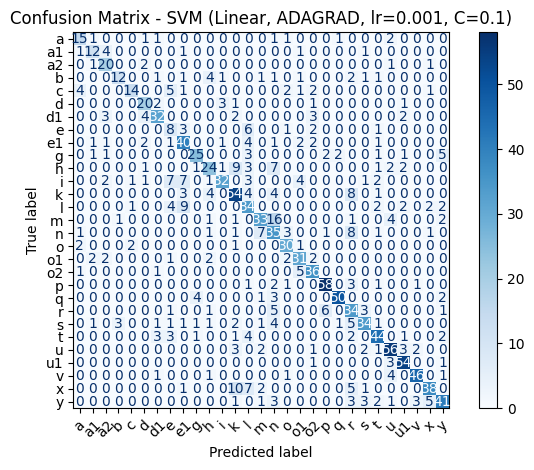

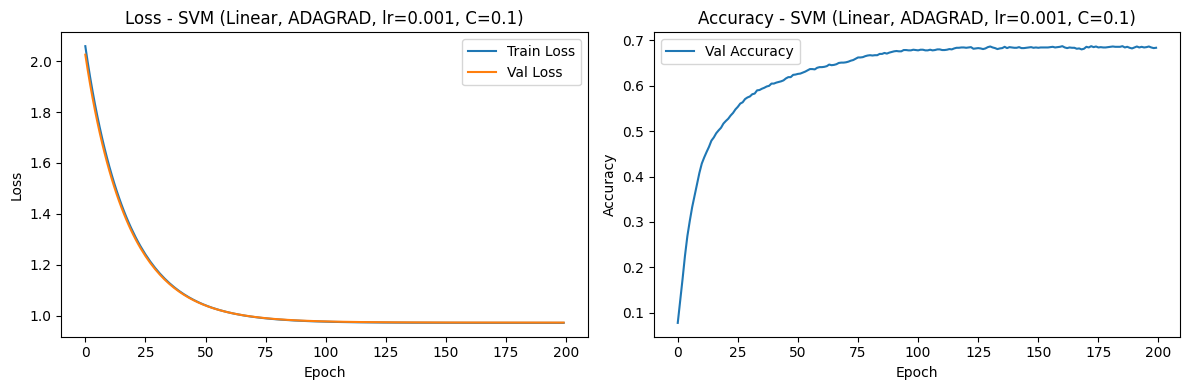


Huấn luyện SVM tuyến tính với optimizer: ADAGRAD, lr=0.001, C=1.0


Training with ADAGRAD: 100%|██████████| 200/200 [03:02<00:00,  1.10it/s]
c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Đánh giá mô hình SVM (Linear, ADAGRAD, lr=0.001, C=1.0):
Accuracy: 0.5942
Precision: 0.6258
Recall: 0.5942
F1-score: 0.5689


<Figure size 1000x800 with 0 Axes>

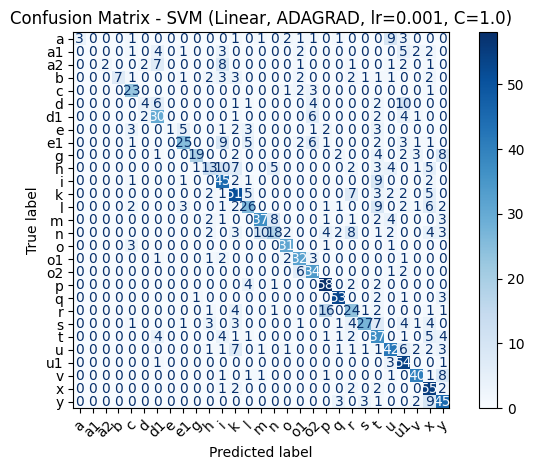

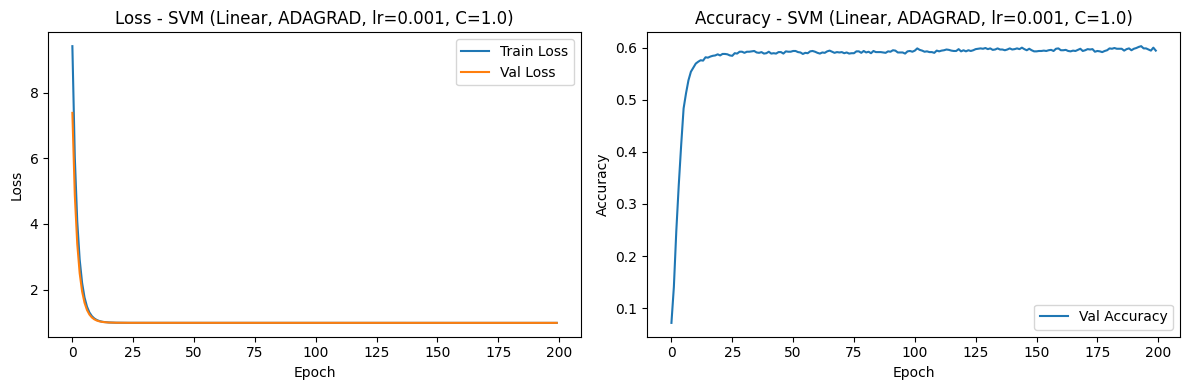

In [26]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

# Hàm chuẩn hóa dữ liệu
def normalize_data(X):
    mean = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True) + 1e-6  # Tránh chia cho 0
    return (X - mean) / std

# Chuẩn hóa dữ liệu
# Giả định X_train_tf, X_test_tf, y_train_tf, y_test_tf là tensor TensorFlow
X_train_np = normalize_data(X_train_tf.numpy())
X_test_np = normalize_data(X_test_tf.numpy())
X_train_tf = tf.convert_to_tensor(X_train_np, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test_np, dtype=tf.float32)

# Lớp LinearSVM
class LinearSVM:
    def __init__(self, input_dim, num_classes, C=1.0):
        self.W = tf.Variable(tf.random.normal([input_dim, num_classes], stddev=0.01, dtype=tf.float32), name='weights')
        self.b = tf.Variable(tf.zeros([num_classes], dtype=tf.float32), name='bias')
        self.C = C  # Hệ số điều chuẩn

    def predict(self, X):
        scores = tf.matmul(X, self.W) + self.b
        return tf.argmax(scores, axis=1)

    def compute_loss(self, X, y_one_hot):
        scores = tf.matmul(X, self.W) + self.b
        margins = tf.maximum(0.0, 1.0 - y_one_hot * scores)
        hinge_loss = tf.reduce_mean(margins)
        l2_loss = 0.5 * self.C * tf.reduce_sum(tf.square(self.W))
        return hinge_loss + l2_loss

# Hàm huấn luyện cải tiến
def train_linear_svm(optimizer_name, X_train, y_train, X_val, y_val, class_to_idx, 
                     epochs=200, batch_size=64, lr=0.01, C=1.0, patience=10):
    model = LinearSVM(X_train.shape[1], len(class_to_idx), C=C)
    
    # Chọn optimizer
    if optimizer_name == 'gd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        use_batch = False  # GD sử dụng toàn bộ dữ liệu
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        use_batch = True
    elif optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        use_batch = True
    elif optimizer_name == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr)
        use_batch = True
    else:
        raise ValueError(f"Optimizer {optimizer_name} không được hỗ trợ.")

    # Cơ chế giảm learning rate thủ công
    current_lr = lr
    min_lr = 1e-6
    lr_factor = 0.5
    lr_patience = 5
    lr_counter = 0
    best_val_loss = float('inf')

    # Early stopping
    patience_counter = 0
    best_weights = None

    # Chuẩn bị dataset
    if use_batch:
        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
    else:
        dataset = [(X_train, y_train)]  # Toàn bộ dữ liệu cho GD

    # Huấn luyện
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in tqdm(range(epochs), desc=f"Training with {optimizer_name.upper()}"):
        train_loss = 0.0
        for X_batch, y_batch in dataset:
            y_one_hot = tf.one_hot(y_batch, len(class_to_idx))
            with tf.GradientTape() as tape:
                loss = model.compute_loss(X_batch, y_one_hot)
            gradients = tape.gradient(loss, [model.W, model.b])
            optimizer.apply_gradients(zip(gradients, [model.W, model.b]))
            train_loss += loss.numpy()
        
        train_loss /= len(dataset)
        history['train_loss'].append(train_loss)

        # Đánh giá trên tập kiểm tra
        y_val_one_hot = tf.one_hot(y_val, len(class_to_idx))
        val_loss = model.compute_loss(X_val, y_val_one_hot).numpy()
        y_pred = model.predict(X_val).numpy()
        val_accuracy = accuracy_score(y_val.numpy(), y_pred)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            lr_counter = 0
            best_weights = {'W': model.W.numpy(), 'b': model.b.numpy()}
        else:
            patience_counter += 1
            lr_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Giảm learning rate thủ công
        if lr_counter >= lr_patience and current_lr > min_lr:
            current_lr *= lr_factor
            print(f"Giảm learning rate xuống {current_lr} tại epoch {epoch+1}")
            optimizer.learning_rate.assign(current_lr)
            lr_counter = 0

    # Khôi phục trọng số tốt nhất
    model.W.assign(best_weights['W'])
    model.b.assign(best_weights['b'])
    return model, history

# Đánh giá và vẽ ma trận nhầm lẫn
def evaluate_model(model, X_test, y_test, class_to_idx, model_name):
    y_pred = model.predict(X_test).numpy()
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    print(f"\nĐánh giá mô hình {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))
    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()

# Danh sách optimizer và siêu tham số
optimizers = ['gd', 'sgd', 'adam', 'adagrad']
learning_rates = [0.01, 0.001]
C_values = [0.1, 1.0]
all_predictions = {}
batch_size = 64
epochs = 200
patience = 10

# Huấn luyện và đánh giá
for opt in optimizers:
    for lr in learning_rates:
        for C in C_values:
            print(f"\nHuấn luyện SVM tuyến tính với optimizer: {opt.upper()}, lr={lr}, C={C}")
            model, history = train_linear_svm(
                optimizer_name=opt,
                X_train=X_train_tf,
                y_train=y_train_tf,
                X_val=X_test_tf,
                y_val=y_test_tf,
                class_to_idx=class_to_idx,
                epochs=epochs,
                batch_size=batch_size,
                lr=lr,
                C=C,
                patience=patience
            )
            
            # Đánh giá mô hình
            model_name = f"SVM (Linear, {opt.upper()}, lr={lr}, C={C})"
            evaluate_model(model, X_test_tf, y_test_tf, class_to_idx, model_name)
            
            # Lưu dự đoán
            y_pred = model.predict(X_test_tf).numpy()
            all_predictions[model_name] = y_pred
            
            # Lưu trọng số
            with open(f'save_model/svm_linear_{opt}_lr{lr}_C{C}_weights.pkl', 'wb') as f:
                pickle.dump({'W': model.W.numpy(), 'b': model.b.numpy()}, f)
            
            # Vẽ lịch sử huấn luyện
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(history['train_loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Val Loss')
            plt.title(f'Loss - {model_name}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.plot(history['val_accuracy'], label='Val Accuracy')
            plt.title(f'Accuracy - {model_name}')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.tight_layout()
            plt.show()


Huấn luyện Logistic Regression với optimizer: GD, lr=0.01, C=0.1


Training with GD: 100%|██████████| 200/200 [00:09<00:00, 21.01it/s]



Đánh giá mô hình Logistic Regression (GD, lr=0.01, C=0.1):
Accuracy: 0.7647
Precision: 0.7659
Recall: 0.7647
F1-score: 0.7626


<Figure size 1000x800 with 0 Axes>

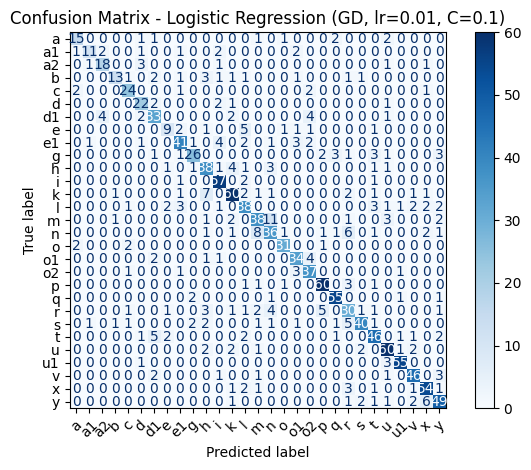

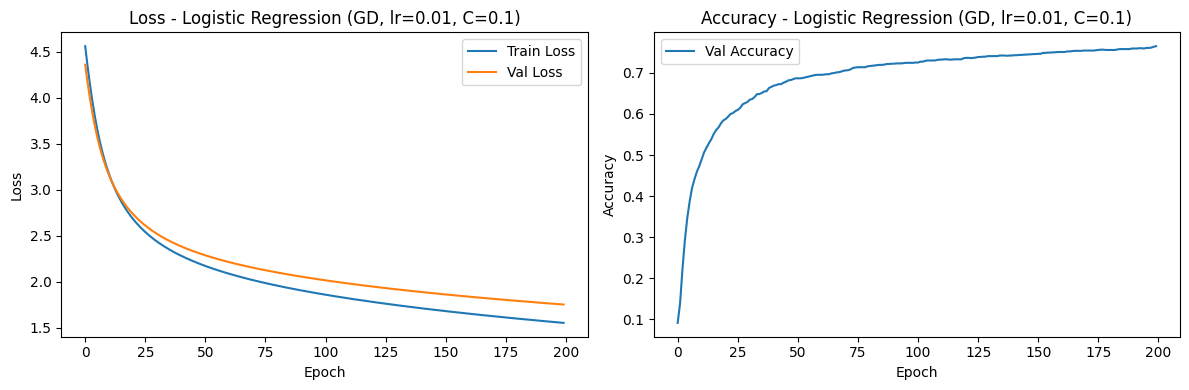


Huấn luyện Logistic Regression với optimizer: GD, lr=0.01, C=1.0


Training with GD: 100%|██████████| 200/200 [00:09<00:00, 20.73it/s]



Đánh giá mô hình Logistic Regression (GD, lr=0.01, C=1.0):
Accuracy: 0.7335
Precision: 0.7351
Recall: 0.7335
F1-score: 0.7290


<Figure size 1000x800 with 0 Axes>

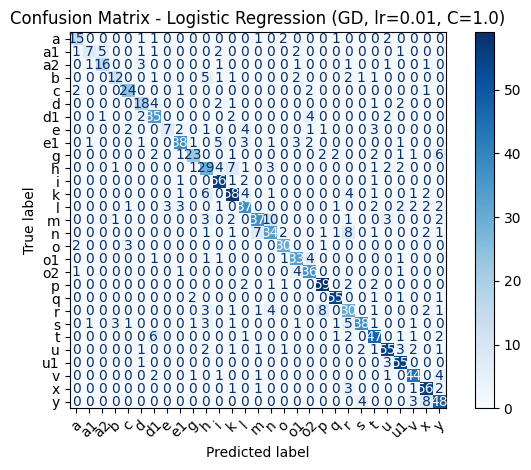

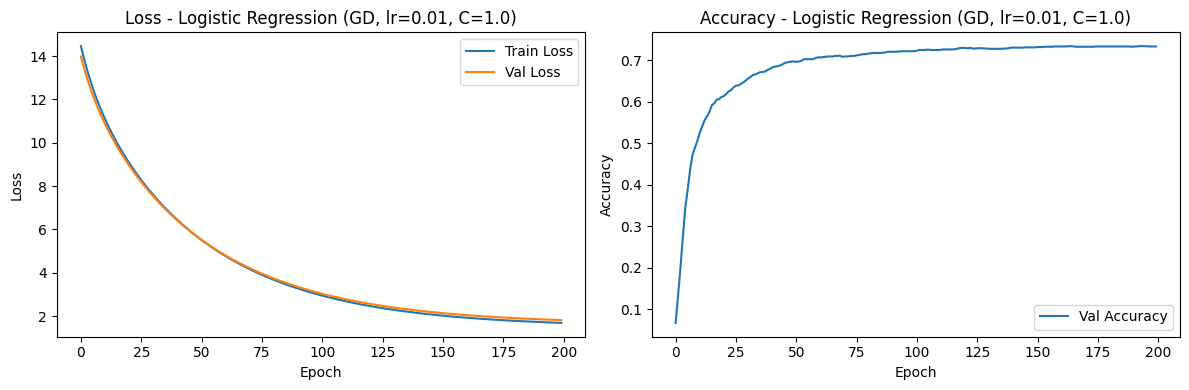


Huấn luyện Logistic Regression với optimizer: GD, lr=0.001, C=0.1


Training with GD: 100%|██████████| 200/200 [00:10<00:00, 19.98it/s]



Đánh giá mô hình Logistic Regression (GD, lr=0.001, C=0.1):
Accuracy: 0.6155
Precision: 0.6208
Recall: 0.6155
F1-score: 0.5928


<Figure size 1000x800 with 0 Axes>

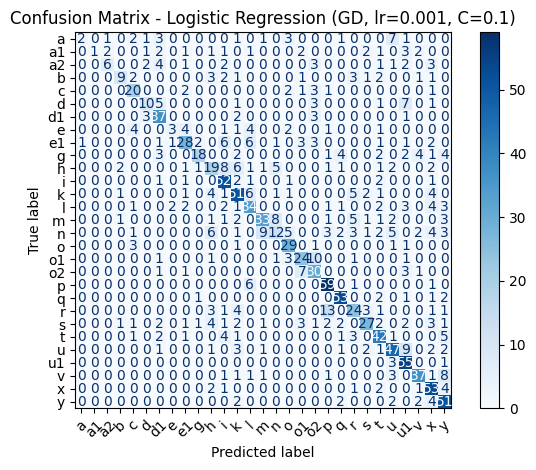

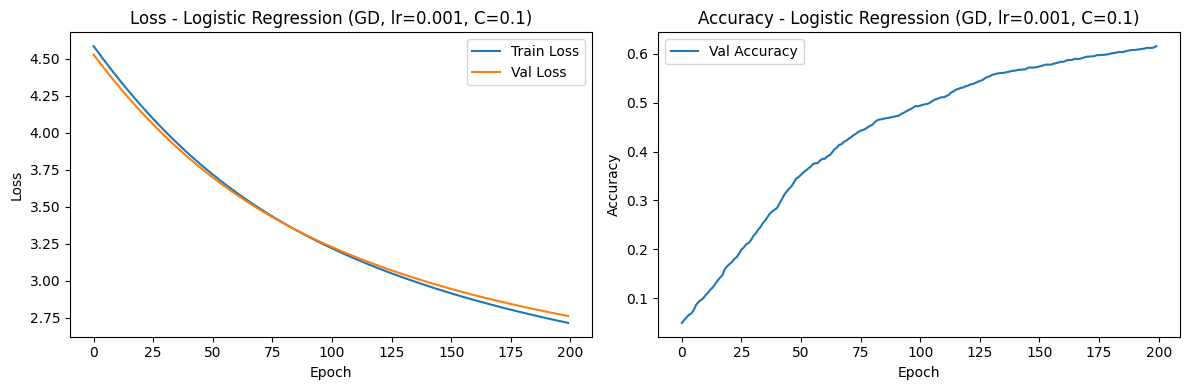


Huấn luyện Logistic Regression với optimizer: GD, lr=0.001, C=1.0


Training with GD: 100%|██████████| 200/200 [00:09<00:00, 20.62it/s]



Đánh giá mô hình Logistic Regression (GD, lr=0.001, C=1.0):
Accuracy: 0.5814
Precision: 0.6059
Recall: 0.5814
F1-score: 0.5593


<Figure size 1000x800 with 0 Axes>

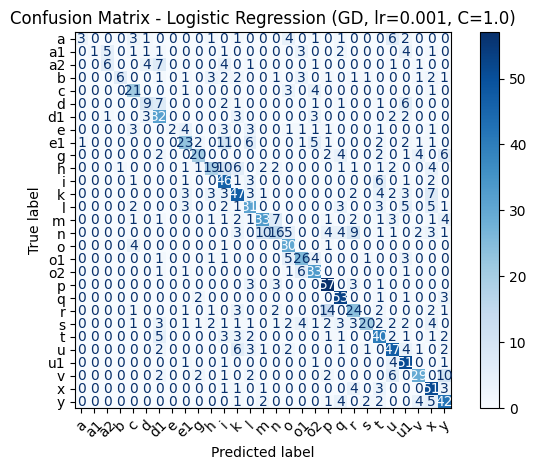

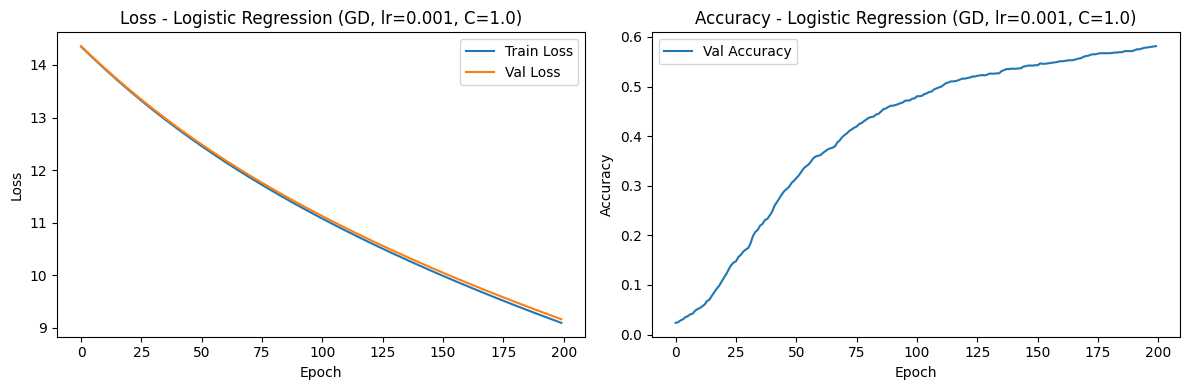


Huấn luyện Logistic Regression với optimizer: SGD, lr=0.01, C=0.1


Training with SGD:   4%|▍         | 9/200 [00:08<02:52,  1.11it/s]

Giảm learning rate xuống 0.005 tại epoch 9


Training with SGD:   8%|▊         | 17/200 [00:15<02:41,  1.13it/s]

Giảm learning rate xuống 0.0025 tại epoch 17


Training with SGD:  12%|█▎        | 25/200 [00:22<02:24,  1.21it/s]

Giảm learning rate xuống 0.00125 tại epoch 25


Training with SGD:  16%|█▋        | 33/200 [00:28<02:14,  1.24it/s]

Giảm learning rate xuống 0.000625 tại epoch 33


Training with SGD:  29%|██▉       | 58/200 [00:53<02:04,  1.14it/s]

Giảm learning rate xuống 0.0003125 tại epoch 58


Training with SGD:  40%|███▉      | 79/200 [01:11<01:41,  1.19it/s]

Giảm learning rate xuống 0.00015625 tại epoch 79


Training with SGD:  45%|████▌     | 90/200 [01:21<01:32,  1.19it/s]

Giảm learning rate xuống 7.8125e-05 tại epoch 90


Training with SGD:  62%|██████▏   | 124/200 [01:49<01:01,  1.23it/s]

Giảm learning rate xuống 3.90625e-05 tại epoch 124


Training with SGD:  72%|███████▏  | 144/200 [02:06<00:46,  1.21it/s]

Giảm learning rate xuống 1.953125e-05 tại epoch 144


Training with SGD:  74%|███████▍  | 148/200 [02:11<00:46,  1.13it/s]

Early stopping at epoch 149

Đánh giá mô hình Logistic Regression (SGD, lr=0.01, C=0.1):
Accuracy: 0.8074
Precision: 0.8101
Recall: 0.8074
F1-score: 0.8066


<Figure size 1000x800 with 0 Axes>

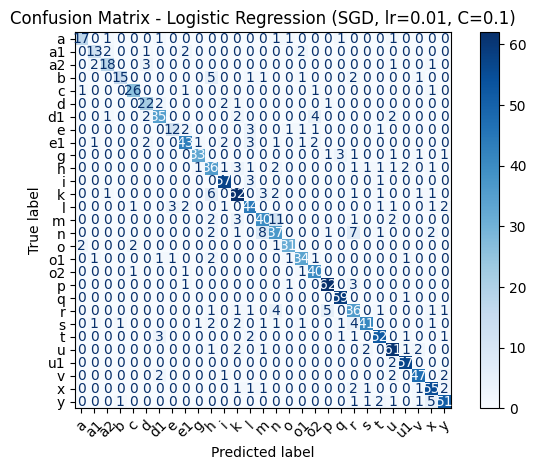

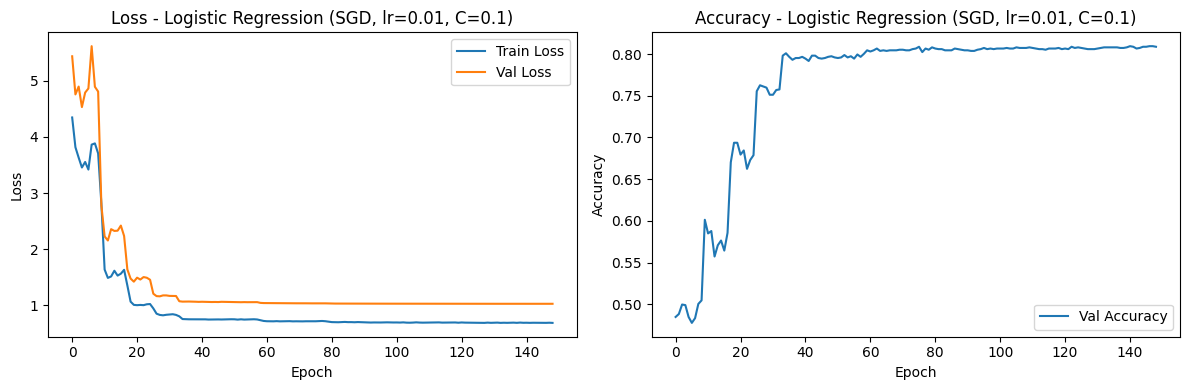


Huấn luyện Logistic Regression với optimizer: SGD, lr=0.01, C=1.0


Training with SGD:   8%|▊         | 15/200 [00:13<02:42,  1.14it/s]

Giảm learning rate xuống 0.005 tại epoch 15


Training with SGD:  12%|█▏        | 24/200 [00:22<02:53,  1.01it/s]

Giảm learning rate xuống 0.0025 tại epoch 24


Training with SGD:  17%|█▋        | 34/200 [00:30<02:14,  1.23it/s]

Giảm learning rate xuống 0.00125 tại epoch 34


Training with SGD:  20%|██        | 41/200 [00:36<02:10,  1.22it/s]

Giảm learning rate xuống 0.000625 tại epoch 41


Training with SGD:  26%|██▌       | 52/200 [00:45<01:54,  1.29it/s]

Giảm learning rate xuống 0.0003125 tại epoch 52


Training with SGD:  39%|███▉      | 78/200 [01:06<01:40,  1.21it/s]

Giảm learning rate xuống 0.00015625 tại epoch 78


Training with SGD:  52%|█████▏    | 103/200 [01:27<01:20,  1.20it/s]

Giảm learning rate xuống 7.8125e-05 tại epoch 103


Training with SGD:  58%|█████▊    | 116/200 [01:38<01:13,  1.15it/s]

Giảm learning rate xuống 3.90625e-05 tại epoch 116


Training with SGD:  65%|██████▌   | 130/200 [01:50<00:56,  1.24it/s]

Giảm learning rate xuống 1.953125e-05 tại epoch 130


Training with SGD:  75%|███████▌  | 150/200 [02:06<00:39,  1.27it/s]

Giảm learning rate xuống 9.765625e-06 tại epoch 150


Training with SGD:  77%|███████▋  | 154/200 [02:10<00:38,  1.18it/s]

Early stopping at epoch 155

Đánh giá mô hình Logistic Regression (SGD, lr=0.01, C=1.0):
Accuracy: 0.7463
Precision: 0.7473
Recall: 0.7463
F1-score: 0.7423


<Figure size 1000x800 with 0 Axes>

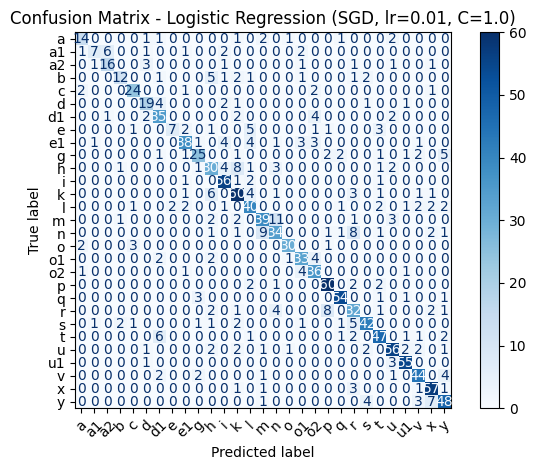

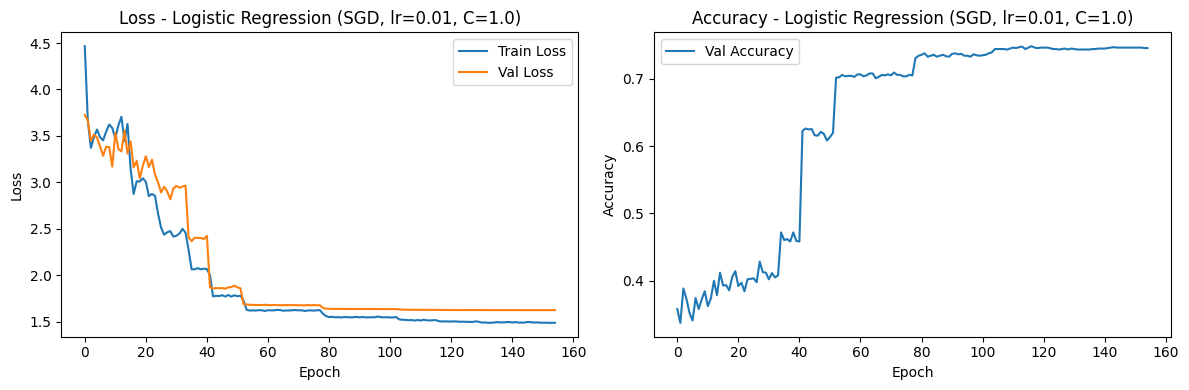


Huấn luyện Logistic Regression với optimizer: SGD, lr=0.001, C=0.1


Training with SGD:  20%|██        | 41/200 [00:34<02:04,  1.27it/s]

Giảm learning rate xuống 0.0005 tại epoch 41


Training with SGD:  34%|███▍      | 68/200 [00:55<01:44,  1.27it/s]

Giảm learning rate xuống 0.00025 tại epoch 68


Training with SGD:  42%|████▏     | 84/200 [01:08<01:38,  1.18it/s]

Giảm learning rate xuống 0.000125 tại epoch 84


Training with SGD:  62%|██████▏   | 123/200 [01:39<01:02,  1.24it/s]

Giảm learning rate xuống 6.25e-05 tại epoch 123


Training with SGD:  68%|██████▊   | 135/200 [01:49<00:54,  1.19it/s]

Giảm learning rate xuống 3.125e-05 tại epoch 135


Training with SGD:  72%|███████▏  | 144/200 [01:56<00:47,  1.19it/s]

Giảm learning rate xuống 1.5625e-05 tại epoch 144


Training with SGD:  74%|███████▍  | 148/200 [02:01<00:42,  1.22it/s]

Early stopping at epoch 149

Đánh giá mô hình Logistic Regression (SGD, lr=0.001, C=0.1):
Accuracy: 0.8060
Precision: 0.8093
Recall: 0.8060
F1-score: 0.8054


<Figure size 1000x800 with 0 Axes>

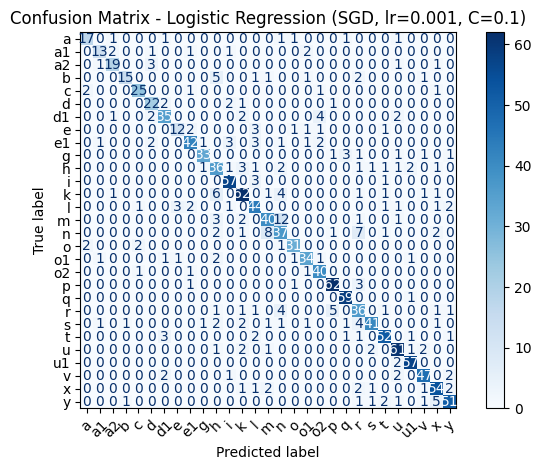

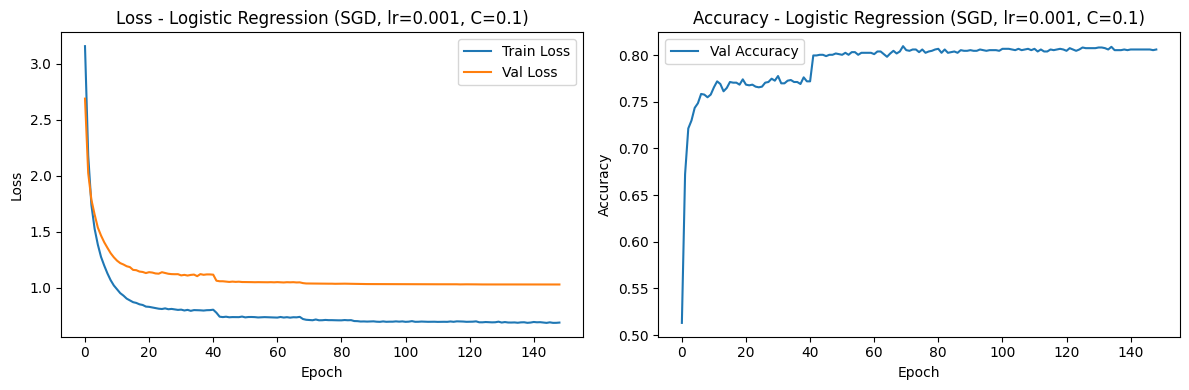


Huấn luyện Logistic Regression với optimizer: SGD, lr=0.001, C=1.0


Training with SGD:   6%|▌         | 11/200 [00:10<02:54,  1.08it/s]

Giảm learning rate xuống 0.0005 tại epoch 11


Training with SGD:  14%|█▎        | 27/200 [00:23<02:19,  1.24it/s]

Giảm learning rate xuống 0.00025 tại epoch 27


Training with SGD:  24%|██▍       | 48/200 [00:40<02:03,  1.23it/s]

Giảm learning rate xuống 0.000125 tại epoch 48


Training with SGD:  35%|███▌      | 70/200 [00:58<01:45,  1.23it/s]

Giảm learning rate xuống 6.25e-05 tại epoch 70


Training with SGD:  52%|█████▏    | 104/200 [01:26<01:14,  1.28it/s]

Giảm learning rate xuống 3.125e-05 tại epoch 104


Training with SGD:  59%|█████▉    | 118/200 [01:36<01:03,  1.29it/s]

Giảm learning rate xuống 1.5625e-05 tại epoch 118


Training with SGD:  69%|██████▉   | 138/200 [01:52<00:47,  1.30it/s]

Giảm learning rate xuống 7.8125e-06 tại epoch 138


Training with SGD:  88%|████████▊ | 176/200 [02:22<00:18,  1.29it/s]

Giảm learning rate xuống 3.90625e-06 tại epoch 176


Training with SGD:  90%|█████████ | 180/200 [02:26<00:16,  1.23it/s]

Early stopping at epoch 181

Đánh giá mô hình Logistic Regression (SGD, lr=0.001, C=1.0):
Accuracy: 0.7420
Precision: 0.7437
Recall: 0.7420
F1-score: 0.7375


<Figure size 1000x800 with 0 Axes>

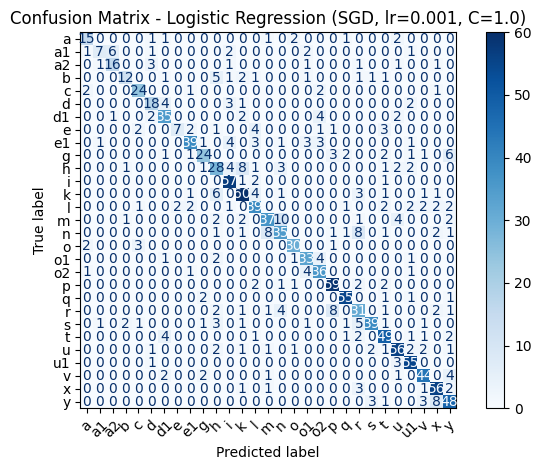

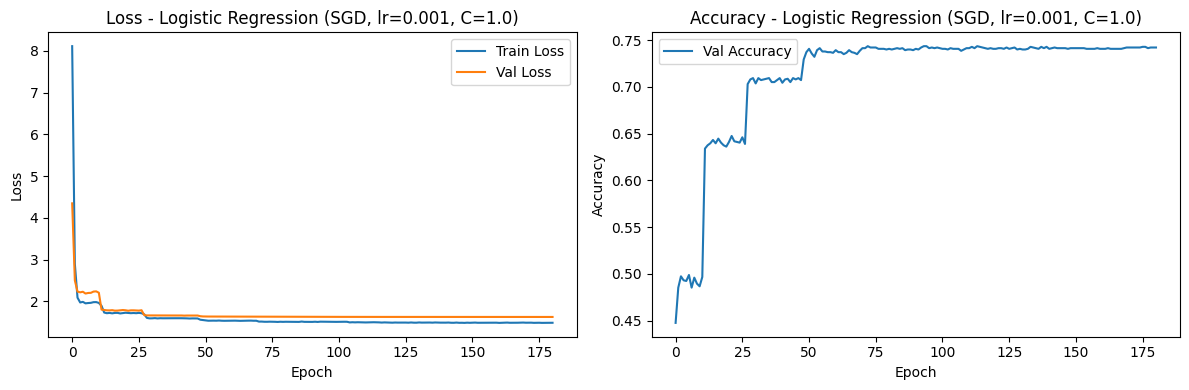


Huấn luyện Logistic Regression với optimizer: ADAM, lr=0.01, C=0.1


Training with ADAM:   3%|▎         | 6/200 [00:07<04:13,  1.31s/it]

Giảm learning rate xuống 0.005 tại epoch 6


Training with ADAM:   6%|▌         | 12/200 [00:15<04:08,  1.32s/it]

Giảm learning rate xuống 0.0025 tại epoch 12


Training with ADAM:  10%|█         | 20/200 [00:26<03:57,  1.32s/it]

Giảm learning rate xuống 0.00125 tại epoch 20


Training with ADAM:  14%|█▎        | 27/200 [00:35<03:46,  1.31s/it]

Giảm learning rate xuống 0.000625 tại epoch 27


Training with ADAM:  18%|█▊        | 35/200 [00:46<03:39,  1.33s/it]

Giảm learning rate xuống 0.0003125 tại epoch 35


Training with ADAM:  21%|██        | 42/200 [00:55<03:35,  1.36s/it]

Giảm learning rate xuống 0.00015625 tại epoch 42


Training with ADAM:  24%|██▍       | 49/200 [01:04<03:18,  1.32s/it]

Giảm learning rate xuống 7.8125e-05 tại epoch 49


Training with ADAM:  28%|██▊       | 57/200 [01:15<03:14,  1.36s/it]

Giảm learning rate xuống 3.90625e-05 tại epoch 57


Training with ADAM:  36%|███▌      | 72/200 [01:36<02:52,  1.35s/it]

Giảm learning rate xuống 1.953125e-05 tại epoch 72


Training with ADAM:  55%|█████▍    | 109/200 [02:26<02:01,  1.34s/it]

Giảm learning rate xuống 9.765625e-06 tại epoch 109


Training with ADAM:  60%|██████    | 121/200 [02:42<01:42,  1.30s/it]

Giảm learning rate xuống 4.8828125e-06 tại epoch 121


Training with ADAM:  72%|███████▏  | 143/200 [03:12<01:18,  1.38s/it]

Giảm learning rate xuống 2.44140625e-06 tại epoch 143


Training with ADAM:  88%|████████▊ | 175/200 [03:54<00:33,  1.33s/it]

Giảm learning rate xuống 1.220703125e-06 tại epoch 175


Training with ADAM: 100%|██████████| 200/200 [04:28<00:00,  1.34s/it]



Đánh giá mô hình Logistic Regression (ADAM, lr=0.01, C=0.1):
Accuracy: 0.8102
Precision: 0.8129
Recall: 0.8102
F1-score: 0.8096


<Figure size 1000x800 with 0 Axes>

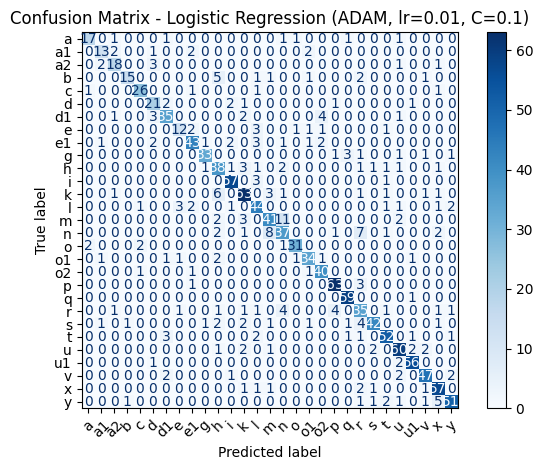

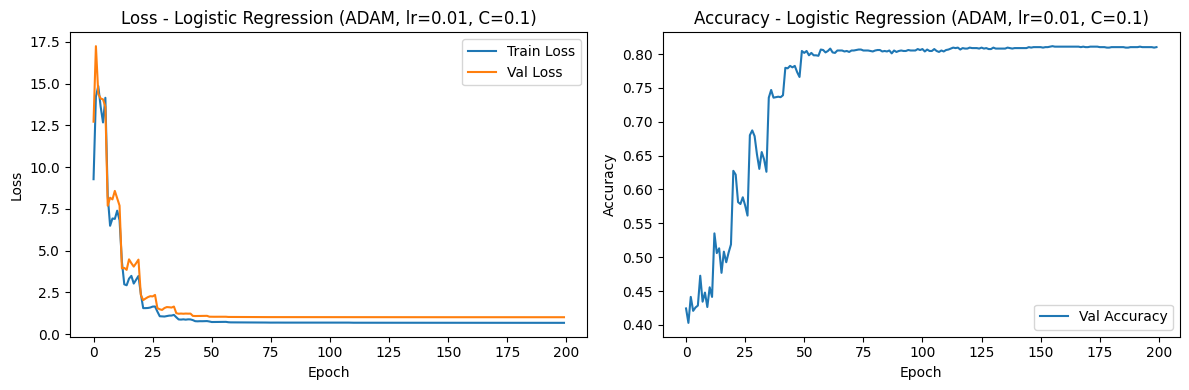


Huấn luyện Logistic Regression với optimizer: ADAM, lr=0.01, C=1.0


Training with ADAM:   4%|▍         | 8/200 [00:11<04:34,  1.43s/it]

Giảm learning rate xuống 0.005 tại epoch 8


Training with ADAM:   9%|▉         | 18/200 [00:24<04:06,  1.36s/it]

Giảm learning rate xuống 0.0025 tại epoch 18


Training with ADAM:  14%|█▎        | 27/200 [00:36<03:55,  1.36s/it]

Giảm learning rate xuống 0.00125 tại epoch 27


Training with ADAM:  19%|█▉        | 38/200 [00:52<03:49,  1.42s/it]

Giảm learning rate xuống 0.000625 tại epoch 38


Training with ADAM:  26%|██▋       | 53/200 [01:13<03:31,  1.44s/it]

Giảm learning rate xuống 0.0003125 tại epoch 53


Training with ADAM:  30%|██▉       | 59/200 [01:21<03:13,  1.37s/it]

Giảm learning rate xuống 0.00015625 tại epoch 59


Training with ADAM:  32%|███▎      | 65/200 [01:29<03:04,  1.37s/it]

Giảm learning rate xuống 7.8125e-05 tại epoch 65


Training with ADAM:  36%|███▋      | 73/200 [01:40<02:53,  1.36s/it]

Giảm learning rate xuống 3.90625e-05 tại epoch 73


Training with ADAM:  43%|████▎     | 86/200 [01:58<02:39,  1.40s/it]

Giảm learning rate xuống 1.953125e-05 tại epoch 86


Training with ADAM:  48%|████▊     | 96/200 [02:12<02:31,  1.46s/it]

Giảm learning rate xuống 9.765625e-06 tại epoch 96


Training with ADAM:  66%|██████▌   | 131/200 [03:01<01:37,  1.42s/it]

Giảm learning rate xuống 4.8828125e-06 tại epoch 131


Training with ADAM:  82%|████████▏ | 164/200 [03:46<00:49,  1.38s/it]

Giảm learning rate xuống 2.44140625e-06 tại epoch 164


Training with ADAM:  84%|████████▍ | 168/200 [03:53<00:44,  1.39s/it]

Early stopping at epoch 169

Đánh giá mô hình Logistic Regression (ADAM, lr=0.01, C=1.0):
Accuracy: 0.7413
Precision: 0.7421
Recall: 0.7413
F1-score: 0.7371


<Figure size 1000x800 with 0 Axes>

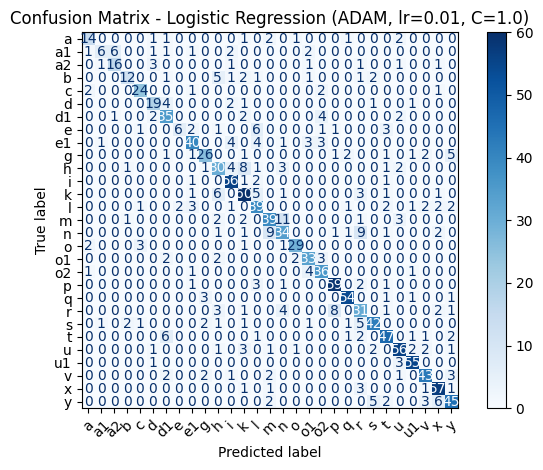

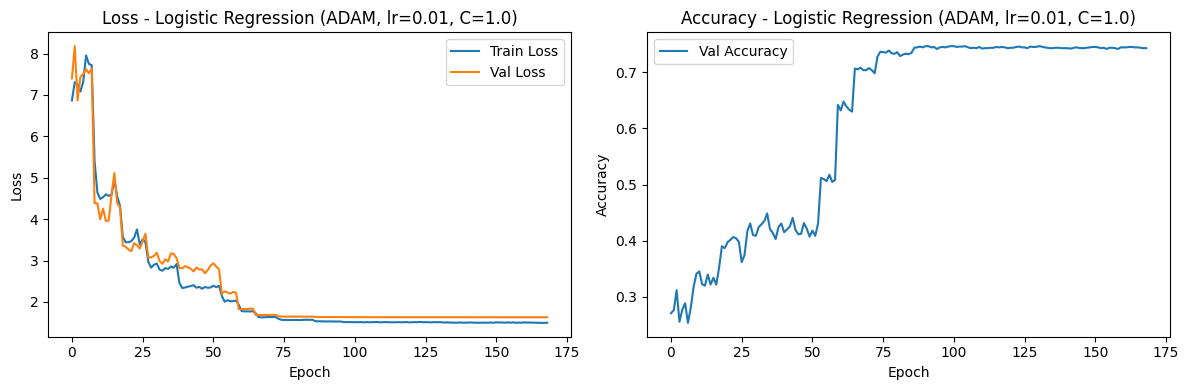


Huấn luyện Logistic Regression với optimizer: ADAM, lr=0.001, C=0.1


Training with ADAM:   8%|▊         | 16/200 [00:22<04:18,  1.41s/it]

Giảm learning rate xuống 0.0005 tại epoch 16


Training with ADAM:  12%|█▏        | 23/200 [00:32<04:03,  1.38s/it]

Giảm learning rate xuống 0.00025 tại epoch 23


Training with ADAM:  16%|█▋        | 33/200 [00:46<03:53,  1.40s/it]

Giảm learning rate xuống 0.000125 tại epoch 33


Training with ADAM:  20%|██        | 40/200 [00:55<03:39,  1.37s/it]

Giảm learning rate xuống 6.25e-05 tại epoch 40


Training with ADAM:  26%|██▌       | 51/200 [01:10<03:24,  1.37s/it]

Giảm learning rate xuống 3.125e-05 tại epoch 51


Training with ADAM:  40%|███▉      | 79/200 [01:49<02:44,  1.36s/it]

Giảm learning rate xuống 1.5625e-05 tại epoch 79


Training with ADAM:  50%|█████     | 101/200 [02:20<02:24,  1.46s/it]

Giảm learning rate xuống 7.8125e-06 tại epoch 101


Training with ADAM:  68%|██████▊   | 137/200 [03:09<01:26,  1.37s/it]

Giảm learning rate xuống 3.90625e-06 tại epoch 137


Training with ADAM:  78%|███████▊  | 156/200 [03:36<01:00,  1.38s/it]

Giảm learning rate xuống 1.953125e-06 tại epoch 156


Training with ADAM:  80%|████████  | 160/200 [03:43<00:55,  1.40s/it]

Early stopping at epoch 161

Đánh giá mô hình Logistic Regression (ADAM, lr=0.001, C=0.1):
Accuracy: 0.8067
Precision: 0.8102
Recall: 0.8067
F1-score: 0.8061


<Figure size 1000x800 with 0 Axes>

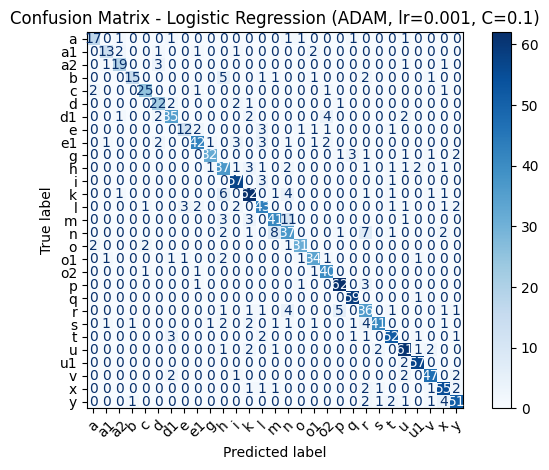

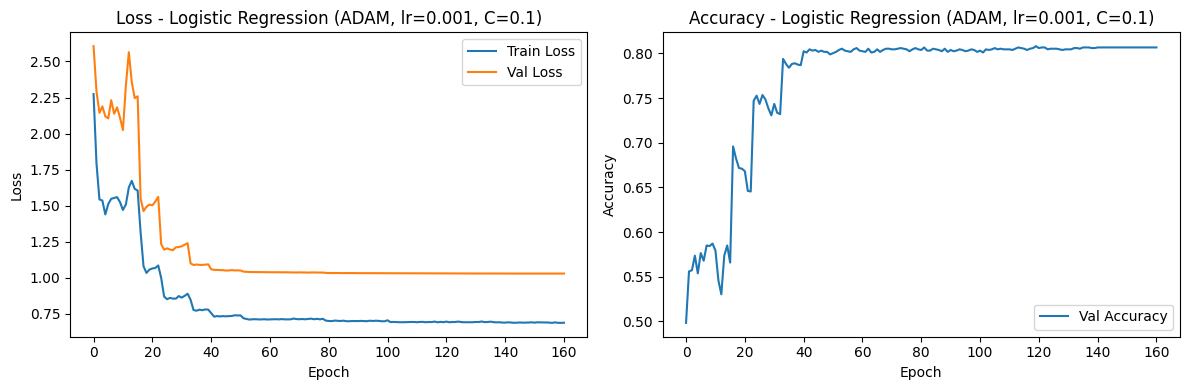


Huấn luyện Logistic Regression với optimizer: ADAM, lr=0.001, C=1.0


Training with ADAM:   3%|▎         | 6/200 [00:08<04:27,  1.38s/it]

Giảm learning rate xuống 0.0005 tại epoch 6


Training with ADAM:   7%|▋         | 14/200 [00:18<04:07,  1.33s/it]

Giảm learning rate xuống 0.00025 tại epoch 14


Training with ADAM:  10%|█         | 20/200 [00:26<03:59,  1.33s/it]

Giảm learning rate xuống 0.000125 tại epoch 20


Training with ADAM:  14%|█▎        | 27/200 [00:36<03:50,  1.33s/it]

Giảm learning rate xuống 6.25e-05 tại epoch 27


Training with ADAM:  17%|█▋        | 34/200 [00:45<03:43,  1.34s/it]

Giảm learning rate xuống 3.125e-05 tại epoch 34


Training with ADAM:  22%|██▏       | 44/200 [00:59<03:27,  1.33s/it]

Giảm learning rate xuống 1.5625e-05 tại epoch 44


Training with ADAM:  36%|███▌      | 72/200 [01:36<02:49,  1.33s/it]

Giảm learning rate xuống 7.8125e-06 tại epoch 72


Training with ADAM:  46%|████▌     | 91/200 [02:02<02:25,  1.33s/it]

Giảm learning rate xuống 3.90625e-06 tại epoch 91


Training with ADAM:  53%|█████▎    | 106/200 [02:22<02:05,  1.34s/it]

Giảm learning rate xuống 1.953125e-06 tại epoch 106


Training with ADAM:  66%|██████▌   | 131/200 [02:55<01:32,  1.34s/it]

Giảm learning rate xuống 9.765625e-07 tại epoch 131


Training with ADAM:  68%|██████▊   | 135/200 [03:03<01:28,  1.36s/it]

Early stopping at epoch 136

Đánh giá mô hình Logistic Regression (ADAM, lr=0.001, C=1.0):
Accuracy: 0.7413
Precision: 0.7433
Recall: 0.7413
F1-score: 0.7366


<Figure size 1000x800 with 0 Axes>

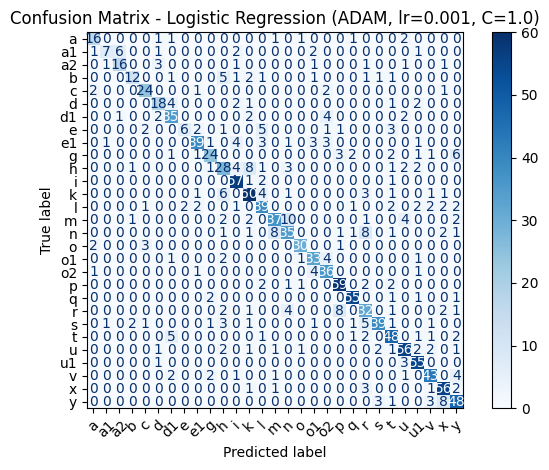

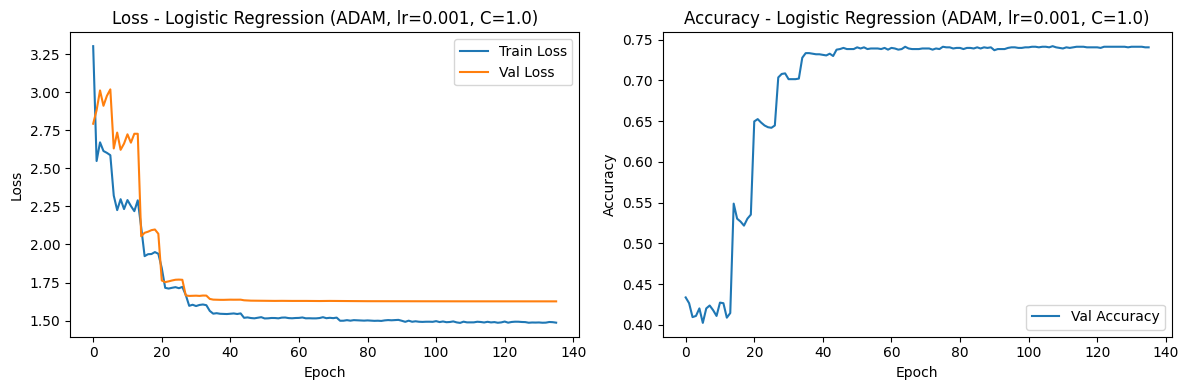


Huấn luyện Logistic Regression với optimizer: ADAGRAD, lr=0.01, C=0.1


Training with ADAGRAD:  20%|█▉        | 39/200 [00:31<02:20,  1.15it/s]

Giảm learning rate xuống 0.005 tại epoch 39


Training with ADAGRAD:  35%|███▌      | 70/200 [00:57<01:48,  1.20it/s]

Giảm learning rate xuống 0.0025 tại epoch 70


Training with ADAGRAD:  46%|████▌     | 92/200 [01:15<01:25,  1.27it/s]

Giảm learning rate xuống 0.00125 tại epoch 92


Training with ADAGRAD:  52%|█████▎    | 105/200 [01:26<01:17,  1.23it/s]

Giảm learning rate xuống 0.000625 tại epoch 105


Training with ADAGRAD:  66%|██████▋   | 133/200 [01:48<00:52,  1.28it/s]

Giảm learning rate xuống 0.0003125 tại epoch 133


Training with ADAGRAD:  68%|██████▊   | 137/200 [01:52<00:51,  1.21it/s]

Early stopping at epoch 138

Đánh giá mô hình Logistic Regression (ADAGRAD, lr=0.01, C=0.1):
Accuracy: 0.8067
Precision: 0.8098
Recall: 0.8067
F1-score: 0.8060


<Figure size 1000x800 with 0 Axes>

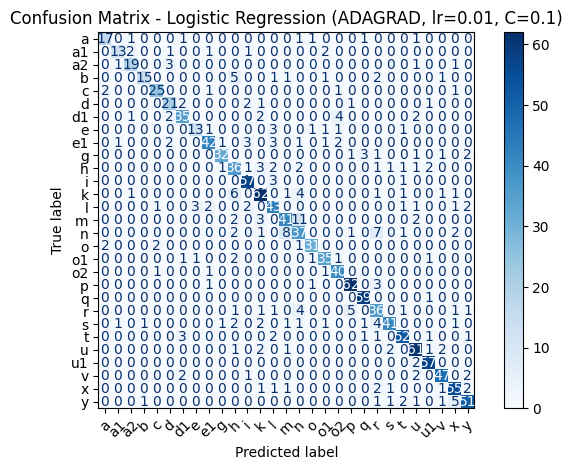

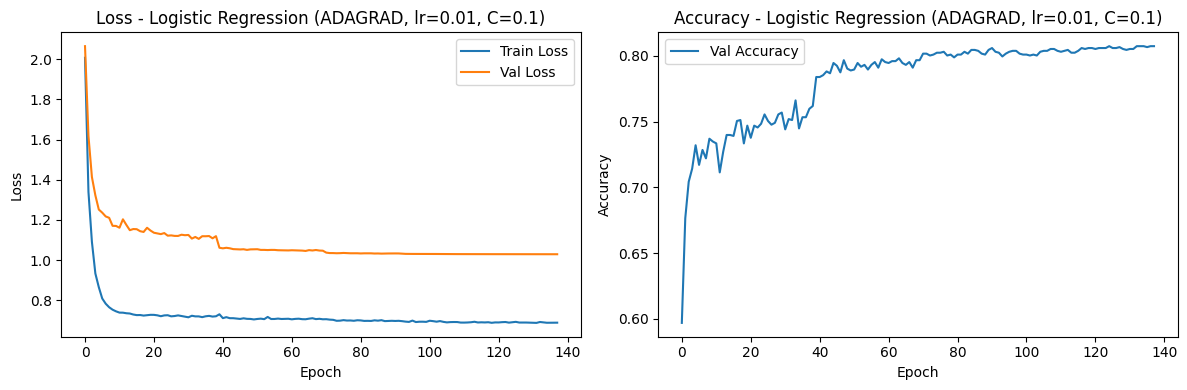


Huấn luyện Logistic Regression với optimizer: ADAGRAD, lr=0.01, C=1.0


Training with ADAGRAD:   7%|▋         | 14/200 [00:11<02:33,  1.21it/s]

Giảm learning rate xuống 0.005 tại epoch 14


Training with ADAGRAD:  22%|██▏       | 43/200 [00:35<02:05,  1.25it/s]

Giảm learning rate xuống 0.0025 tại epoch 43


Training with ADAGRAD:  32%|███▎      | 65/200 [00:53<01:47,  1.26it/s]

Giảm learning rate xuống 0.00125 tại epoch 65


Training with ADAGRAD:  43%|████▎     | 86/200 [01:10<01:31,  1.25it/s]

Giảm learning rate xuống 0.000625 tại epoch 86


Training with ADAGRAD:  51%|█████     | 102/200 [01:23<01:20,  1.22it/s]

Giảm learning rate xuống 0.0003125 tại epoch 102


Training with ADAGRAD:  53%|█████▎    | 106/200 [01:27<01:17,  1.21it/s]

Early stopping at epoch 107

Đánh giá mô hình Logistic Regression (ADAGRAD, lr=0.01, C=1.0):
Accuracy: 0.7406
Precision: 0.7424
Recall: 0.7406
F1-score: 0.7349


<Figure size 1000x800 with 0 Axes>

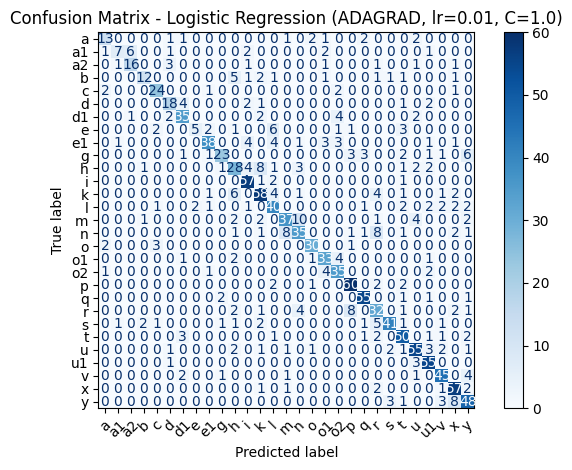

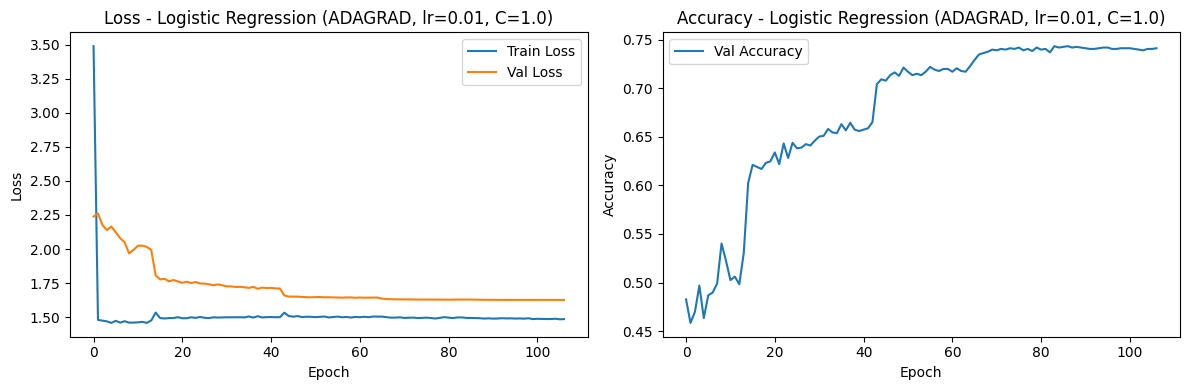


Huấn luyện Logistic Regression với optimizer: ADAGRAD, lr=0.001, C=0.1


Training with ADAGRAD: 100%|██████████| 200/200 [02:55<00:00,  1.14it/s]



Đánh giá mô hình Logistic Regression (ADAGRAD, lr=0.001, C=0.1):
Accuracy: 0.8045
Precision: 0.8074
Recall: 0.8045
F1-score: 0.8036


<Figure size 1000x800 with 0 Axes>

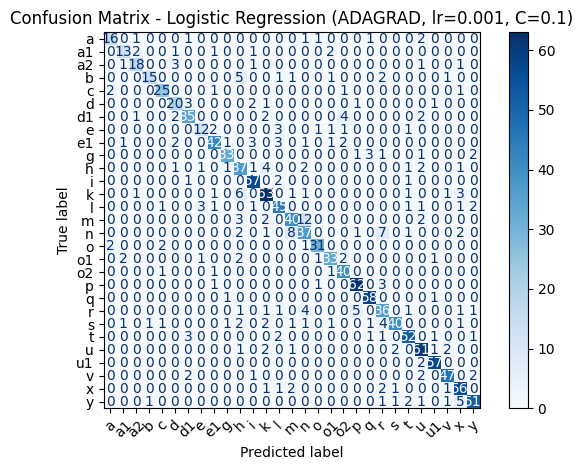

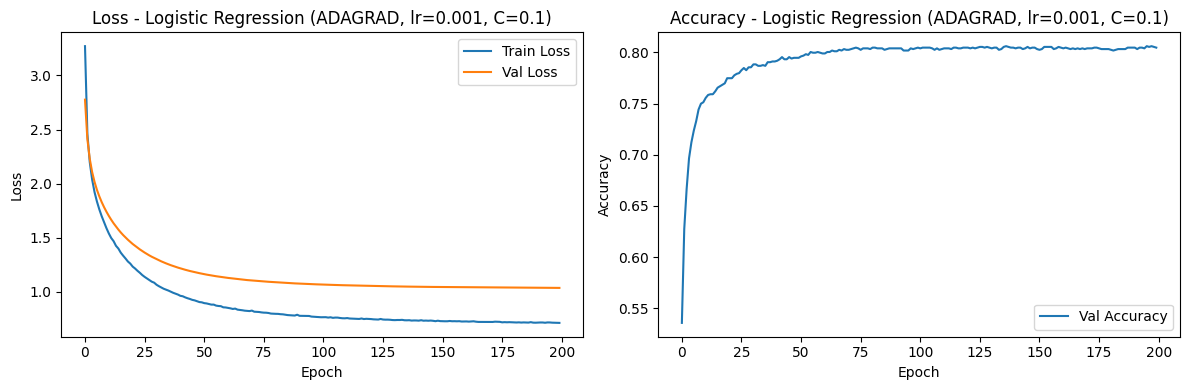


Huấn luyện Logistic Regression với optimizer: ADAGRAD, lr=0.001, C=1.0


Training with ADAGRAD:  30%|███       | 60/200 [00:49<01:55,  1.21it/s]

Giảm learning rate xuống 0.0005 tại epoch 60


Training with ADAGRAD:  44%|████▎     | 87/200 [01:10<01:32,  1.22it/s]

Giảm learning rate xuống 0.00025 tại epoch 87


Training with ADAGRAD:  46%|████▌     | 91/200 [01:15<01:30,  1.21it/s]

Early stopping at epoch 92

Đánh giá mô hình Logistic Regression (ADAGRAD, lr=0.001, C=1.0):
Accuracy: 0.7399
Precision: 0.7418
Recall: 0.7399
F1-score: 0.7342


<Figure size 1000x800 with 0 Axes>

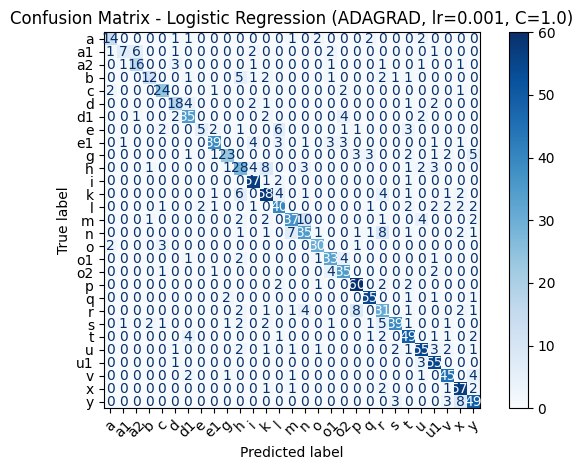

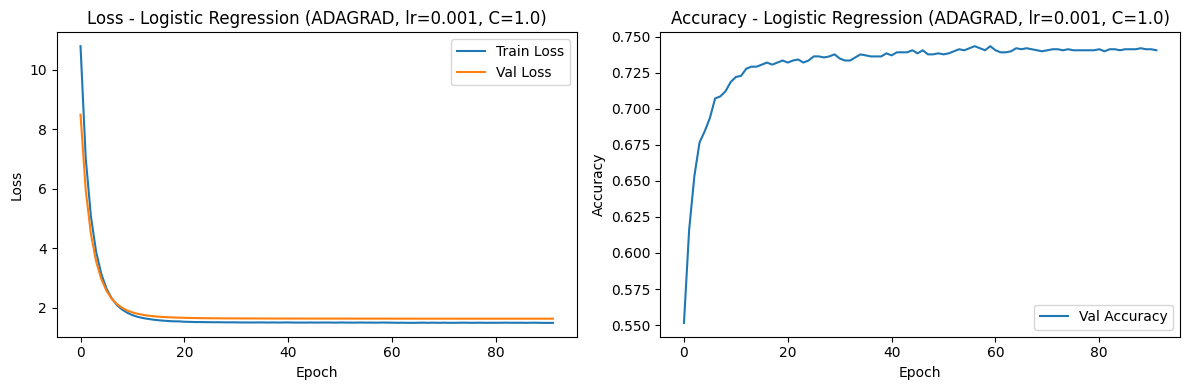

In [27]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

# Lớp LogisticRegression
class LogisticRegressionTF:
    def __init__(self, input_dim, num_classes, C=1.0):
        self.W = tf.Variable(tf.random.normal([input_dim, num_classes], stddev=0.01, dtype=tf.float32), name='weights')
        self.b = tf.Variable(tf.zeros([num_classes], dtype=tf.float32), name='bias')
        self.C = C  # Hệ số điều chuẩn

    def predict(self, X):
        logits = tf.matmul(X, self.W) + self.b
        return tf.argmax(logits, axis=1)
    
    def compute_probs(self, X):
        logits = tf.matmul(X, self.W) + self.b
        return tf.nn.softmax(logits, axis=1)
    
    def compute_loss(self, X, y_indices):
        logits = tf.matmul(X, self.W) + self.b
        # Cross-entropy loss
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y_indices, logits=logits)
        loss = tf.reduce_mean(cross_entropy)
        # L2 regularization
        l2_loss = 0.5 * self.C * tf.reduce_sum(tf.square(self.W))
        return loss + l2_loss

# Hàm huấn luyện cho Logistic Regression
def train_logistic_regression(optimizer_name, X_train, y_train, X_val, y_val, class_to_idx, 
                     epochs=200, batch_size=64, lr=0.01, C=1.0, patience=10):
    model = LogisticRegressionTF(X_train.shape[1], len(class_to_idx), C=C)
    
    # Chọn optimizer
    if optimizer_name == 'gd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        use_batch = False  # GD sử dụng toàn bộ dữ liệu
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        use_batch = True
    elif optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        use_batch = True
    elif optimizer_name == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr)
        use_batch = True
    else:
        raise ValueError(f"Optimizer {optimizer_name} không được hỗ trợ.")

    # Cơ chế giảm learning rate thủ công
    current_lr = lr
    min_lr = 1e-6
    lr_factor = 0.5
    lr_patience = 5
    lr_counter = 0
    best_val_loss = float('inf')

    # Early stopping
    patience_counter = 0
    best_weights = None

    # Chuẩn bị dataset
    if use_batch:
        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
    else:
        dataset = [(X_train, y_train)]  # Toàn bộ dữ liệu cho GD

    # Huấn luyện
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in tqdm(range(epochs), desc=f"Training with {optimizer_name.upper()}"):
        train_loss = 0.0
        for X_batch, y_batch in dataset:
            with tf.GradientTape() as tape:
                loss = model.compute_loss(X_batch, y_batch)
            gradients = tape.gradient(loss, [model.W, model.b])
            optimizer.apply_gradients(zip(gradients, [model.W, model.b]))
            train_loss += loss.numpy()
        
        train_loss /= len(dataset)
        history['train_loss'].append(train_loss)

        # Đánh giá trên tập kiểm tra
        val_loss = model.compute_loss(X_val, y_val).numpy()
        y_pred = model.predict(X_val).numpy()
        val_accuracy = accuracy_score(y_val.numpy(), y_pred)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            lr_counter = 0
            best_weights = {'W': model.W.numpy(), 'b': model.b.numpy()}
        else:
            patience_counter += 1
            lr_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Giảm learning rate thủ công
        if lr_counter >= lr_patience and current_lr > min_lr:
            current_lr *= lr_factor
            print(f"Giảm learning rate xuống {current_lr} tại epoch {epoch+1}")
            optimizer.learning_rate.assign(current_lr)
            lr_counter = 0

    # Khôi phục trọng số tốt nhất
    model.W.assign(best_weights['W'])
    model.b.assign(best_weights['b'])
    return model, history

# Đánh giá và vẽ ma trận nhầm lẫn (giữ nguyên từ mã SVM)
def evaluate_model(model, X_test, y_test, class_to_idx, model_name):
    y_pred = model.predict(X_test).numpy()
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    print(f"\nĐánh giá mô hình {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))
    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()

# Danh sách optimizer và siêu tham số
optimizers = ['gd', 'sgd', 'adam', 'adagrad']
learning_rates = [0.01, 0.001]
C_values = [0.1, 1.0]
all_predictions = {}
batch_size = 64
epochs = 200
patience = 10

# Huấn luyện và đánh giá
for opt in optimizers:
    for lr in learning_rates:
        for C in C_values:
            print(f"\nHuấn luyện Logistic Regression với optimizer: {opt.upper()}, lr={lr}, C={C}")
            model, history = train_logistic_regression(
                optimizer_name=opt,
                X_train=X_train_tf,
                y_train=y_train_tf,
                X_val=X_test_tf,
                y_val=y_test_tf,
                class_to_idx=class_to_idx,
                epochs=epochs,
                batch_size=batch_size,
                lr=lr,
                C=C,
                patience=patience
            )
            
            # Đánh giá mô hình
            model_name = f"Logistic Regression ({opt.upper()}, lr={lr}, C={C})"
            evaluate_model(model, X_test_tf, y_test_tf, class_to_idx, model_name)
            
            # Lưu dự đoán
            y_pred = model.predict(X_test_tf).numpy()
            all_predictions[model_name] = y_pred
            
            # Lưu trọng số
            with open(f'save_model/logistic_{opt}_lr{lr}_C{C}_weights.pkl', 'wb') as f:
                pickle.dump({'W': model.W.numpy(), 'b': model.b.numpy()}, f)
            
            # Vẽ lịch sử huấn luyện
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(history['train_loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Val Loss')
            plt.title(f'Loss - {model_name}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.plot(history['val_accuracy'], label='Val Accuracy')
            plt.title(f'Accuracy - {model_name}')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.tight_layout()
            plt.show()